## 3.3构建变分自编码器
自编码器通过编码器把图像直接映射成隐空间中的一点，在变分自编码器中，每个图像通过编码器映射成隐空间中围绕某个点的多元正态分布，如图3-15所示。
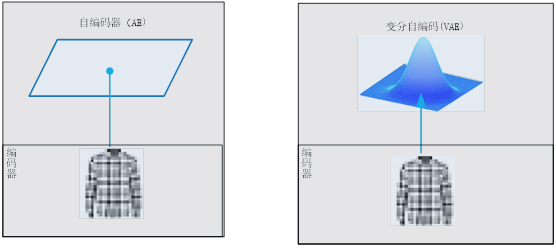

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchsummary import summary
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Hyperparameters
random_seed = 456
learning_rate = 0.005
num_epochs = 10
batch_size=256

## 数据集介绍

|标签	|描述|
|:-|:-|
|0	|T恤（T-shirt/top）|
|1	|裤子（Trouser）|
|2	|套头衫（Pullover）|
|3	|连衣裙（Dress）|
|4	|外套（Coat）|
|5	|凉鞋（Sandal）|
|6	|衬衫（Shirt）|
|7	|运动鞋（Sneaker）|
|8	|包（Bag）|
|9	|靴子（Ankle boot）|

- 60000张训练图像和对应Label；
- 10000张测试图像和对应Label；
- 10个类别；
- 每张图像28x28的分辨率；

In [3]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, transform=transforms.ToTensor(),download=False)
test_dataset = datasets.FashionMNIST(root='../data', train=False, transform=transforms.ToTensor())

#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
#test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [4]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 可视化训练数据

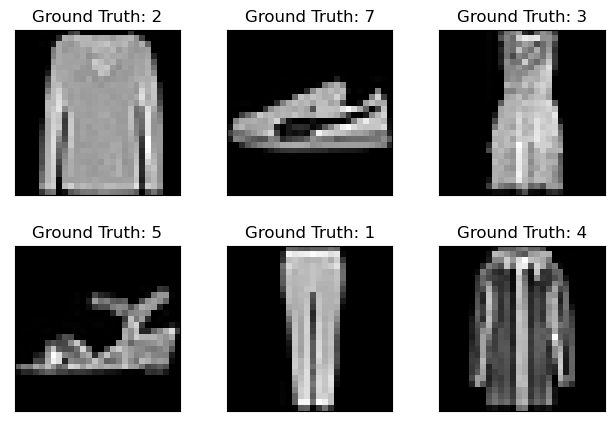

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  #plt.imshow(example_data[i][0], cmap='binary', interpolation='none')
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## 构建编码器
编码器模型的网络结构如图3-16所示。
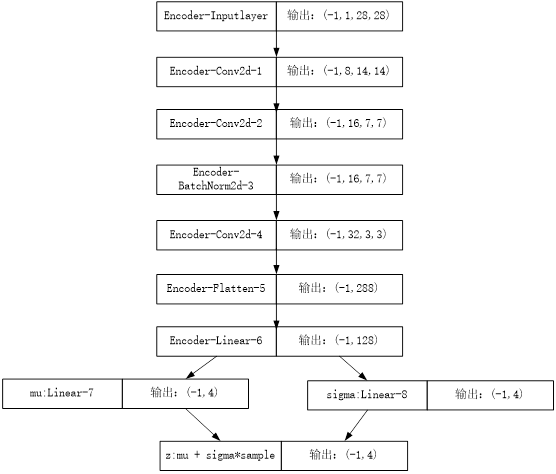
  图3-16 VAE的编码器的网络结构
图3-16的输出如下：
$$z=u(:mu)+σ(:sigma)ε$$
其中，ε是标准正态分布的采样。
VAE的编码器的代码如下：

In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)
        #定义一个标准正太分布
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #展平为一维数据
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        #定义编码器的输出
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

## 构建解码器
解码器的网络结构如图3-17所示。
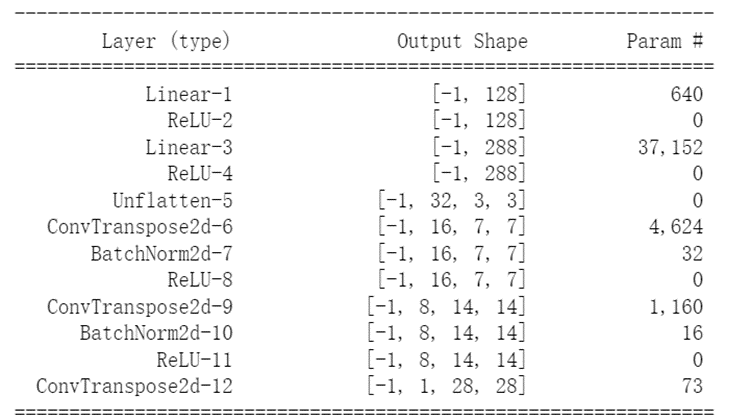

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 可视化模型结构

In [9]:
latent_dims=4
encoder = VariationalEncoder(latent_dims)
encoder=encoder.to(device)
decoder = Decoder(latent_dims)
decoder=decoder.to(device)

In [10]:
summary( encoder,(1,28,28),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
            Conv2d-2             [-1, 16, 7, 7]           1,168
       BatchNorm2d-3             [-1, 16, 7, 7]              32
            Conv2d-4             [-1, 32, 3, 3]           4,640
            Linear-5                  [-1, 128]          36,992
            Linear-6                    [-1, 4]             516
            Linear-7                    [-1, 4]             516
Total params: 43,944
Trainable params: 43,944
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.17
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [11]:
summary( decoder,(4,),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 288]          37,152
              ReLU-4                  [-1, 288]               0
         Unflatten-5             [-1, 32, 3, 3]               0
   ConvTranspose2d-6             [-1, 16, 7, 7]           4,624
       BatchNorm2d-7             [-1, 16, 7, 7]              32
              ReLU-8             [-1, 16, 7, 7]               0
   ConvTranspose2d-9            [-1, 8, 14, 14]           1,160
      BatchNorm2d-10            [-1, 8, 14, 14]              16
             ReLU-11            [-1, 8, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]              73
Total params: 43,697
Trainable params: 43,697
Non-trainable params: 0
---------------------------------

## 定义损失函数

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 训练评估模型

In [13]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

## 测试模型

In [14]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

## 可视化运行结果

In [15]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 48658.960938
	 partial train loss (single batch): 48562.730469
	 partial train loss (single batch): 46426.332031
	 partial train loss (single batch): 46007.878906
	 partial train loss (single batch): 44771.570312
	 partial train loss (single batch): 44264.570312
	 partial train loss (single batch): 42717.316406
	 partial train loss (single batch): 43226.718750
	 partial train loss (single batch): 41976.375000
	 partial train loss (single batch): 42046.242188
	 partial train loss (single batch): 40795.679688
	 partial train loss (single batch): 41020.011719
	 partial train loss (single batch): 41105.949219
	 partial train loss (single batch): 39637.972656
	 partial train loss (single batch): 39808.074219
	 partial train loss (single batch): 38775.132812
	 partial train loss (single batch): 38766.582031
	 partial train loss (single batch): 39164.468750
	 partial train loss (single batch): 38612.824219
	 partial train loss (single batch): 37754.183594


	 partial train loss (single batch): 14147.948242
	 partial train loss (single batch): 14219.590820
	 partial train loss (single batch): 14358.101562
	 partial train loss (single batch): 14397.083984
	 partial train loss (single batch): 14179.361328
	 partial train loss (single batch): 14303.480469
	 partial train loss (single batch): 13887.471680
	 partial train loss (single batch): 14063.379883
	 partial train loss (single batch): 14087.962891
	 partial train loss (single batch): 13419.942383
	 partial train loss (single batch): 13964.400391
	 partial train loss (single batch): 13642.950195
	 partial train loss (single batch): 13577.078125
	 partial train loss (single batch): 13413.040039
	 partial train loss (single batch): 13692.259766
	 partial train loss (single batch): 13701.054688
	 partial train loss (single batch): 13813.030273
	 partial train loss (single batch): 13493.546875
	 partial train loss (single batch): 13448.020508
	 partial train loss (single batch): 6571.000000



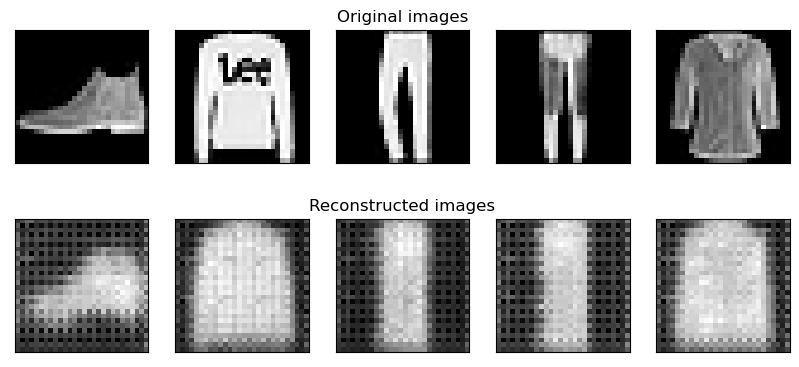

	 partial train loss (single batch): 13046.253906
	 partial train loss (single batch): 13178.053711
	 partial train loss (single batch): 13069.429688
	 partial train loss (single batch): 13542.512695
	 partial train loss (single batch): 12697.494141
	 partial train loss (single batch): 12911.779297
	 partial train loss (single batch): 12920.583984
	 partial train loss (single batch): 13091.832031
	 partial train loss (single batch): 12539.160156
	 partial train loss (single batch): 12683.833984
	 partial train loss (single batch): 12723.756836
	 partial train loss (single batch): 12610.792969
	 partial train loss (single batch): 12835.573242
	 partial train loss (single batch): 12308.715820
	 partial train loss (single batch): 12603.902344
	 partial train loss (single batch): 12220.115234
	 partial train loss (single batch): 12281.746094
	 partial train loss (single batch): 12373.572266
	 partial train loss (single batch): 12105.001953
	 partial train loss (single batch): 12154.029297


	 partial train loss (single batch): 8470.330078
	 partial train loss (single batch): 8462.720703
	 partial train loss (single batch): 8595.382812
	 partial train loss (single batch): 8678.408203
	 partial train loss (single batch): 8669.059570
	 partial train loss (single batch): 8775.072266
	 partial train loss (single batch): 8667.620117
	 partial train loss (single batch): 8607.492188
	 partial train loss (single batch): 8645.402344
	 partial train loss (single batch): 8383.661133
	 partial train loss (single batch): 8832.384766
	 partial train loss (single batch): 8406.103516
	 partial train loss (single batch): 8597.031250
	 partial train loss (single batch): 8312.535156
	 partial train loss (single batch): 8528.538086
	 partial train loss (single batch): 8594.996094
	 partial train loss (single batch): 8657.802734
	 partial train loss (single batch): 8655.944336
	 partial train loss (single batch): 8438.113281
	 partial train loss (single batch): 4256.910156

 EPOCH 2/50 	 train

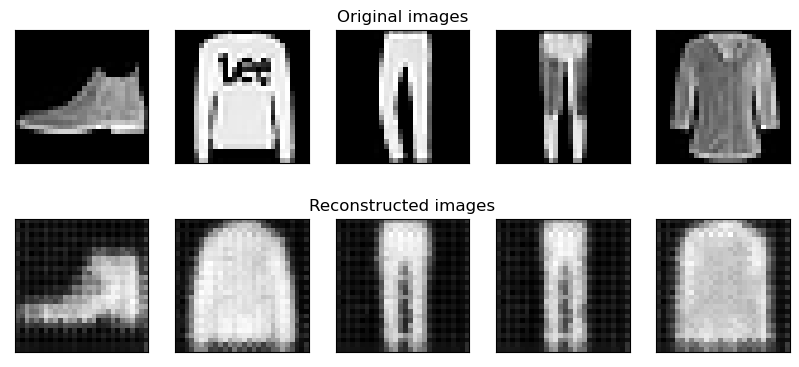

	 partial train loss (single batch): 8603.681641
	 partial train loss (single batch): 8529.791992
	 partial train loss (single batch): 8710.450195
	 partial train loss (single batch): 8981.954102
	 partial train loss (single batch): 8371.089844
	 partial train loss (single batch): 8505.159180
	 partial train loss (single batch): 8732.491211
	 partial train loss (single batch): 8617.692383
	 partial train loss (single batch): 8278.154297
	 partial train loss (single batch): 8296.152344
	 partial train loss (single batch): 8456.902344
	 partial train loss (single batch): 8419.440430
	 partial train loss (single batch): 8570.260742
	 partial train loss (single batch): 8304.257812
	 partial train loss (single batch): 8611.359375
	 partial train loss (single batch): 8234.940430
	 partial train loss (single batch): 8578.574219
	 partial train loss (single batch): 8527.020508
	 partial train loss (single batch): 8265.794922
	 partial train loss (single batch): 8438.275391
	 partial train loss

	 partial train loss (single batch): 7654.551758
	 partial train loss (single batch): 7610.479492
	 partial train loss (single batch): 7775.507812
	 partial train loss (single batch): 7802.099121
	 partial train loss (single batch): 7789.602051
	 partial train loss (single batch): 7850.725586
	 partial train loss (single batch): 7851.424316
	 partial train loss (single batch): 7681.940918
	 partial train loss (single batch): 7845.894531
	 partial train loss (single batch): 7610.623047
	 partial train loss (single batch): 7987.247070
	 partial train loss (single batch): 7578.326660
	 partial train loss (single batch): 7739.479492
	 partial train loss (single batch): 7535.914062
	 partial train loss (single batch): 7693.055176
	 partial train loss (single batch): 7762.387695
	 partial train loss (single batch): 7734.835938
	 partial train loss (single batch): 7818.356445
	 partial train loss (single batch): 7591.654297
	 partial train loss (single batch): 3935.120117

 EPOCH 3/50 	 train

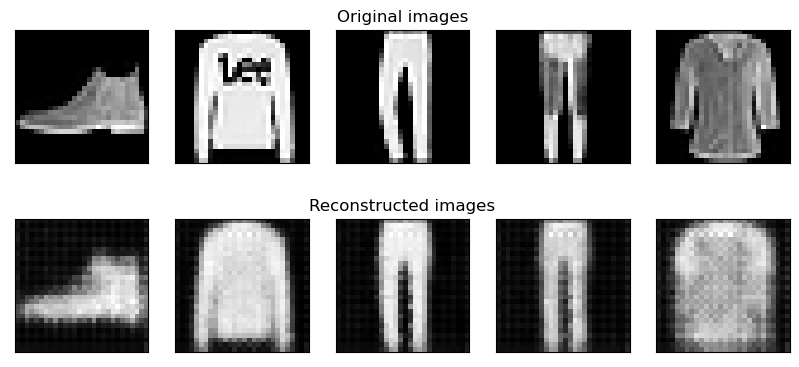

	 partial train loss (single batch): 7894.722168
	 partial train loss (single batch): 7769.084961
	 partial train loss (single batch): 7934.650391
	 partial train loss (single batch): 8190.176758
	 partial train loss (single batch): 7516.045898
	 partial train loss (single batch): 7741.887207
	 partial train loss (single batch): 8034.634766
	 partial train loss (single batch): 7848.901367
	 partial train loss (single batch): 7479.864258
	 partial train loss (single batch): 7488.610352
	 partial train loss (single batch): 7722.161133
	 partial train loss (single batch): 7719.290039
	 partial train loss (single batch): 7838.420898
	 partial train loss (single batch): 7612.494141
	 partial train loss (single batch): 7888.841797
	 partial train loss (single batch): 7538.424805
	 partial train loss (single batch): 7955.134766
	 partial train loss (single batch): 7835.708984
	 partial train loss (single batch): 7523.487793
	 partial train loss (single batch): 7754.156250
	 partial train loss

	 partial train loss (single batch): 7364.255859
	 partial train loss (single batch): 7209.619629
	 partial train loss (single batch): 7396.144043
	 partial train loss (single batch): 7432.586914
	 partial train loss (single batch): 7399.999023
	 partial train loss (single batch): 7441.215332
	 partial train loss (single batch): 7450.820801
	 partial train loss (single batch): 7274.184082
	 partial train loss (single batch): 7411.474121
	 partial train loss (single batch): 7244.296875
	 partial train loss (single batch): 7622.597656
	 partial train loss (single batch): 7162.817383
	 partial train loss (single batch): 7369.172363
	 partial train loss (single batch): 7145.935547
	 partial train loss (single batch): 7314.057617
	 partial train loss (single batch): 7364.320801
	 partial train loss (single batch): 7386.609375
	 partial train loss (single batch): 7429.808594
	 partial train loss (single batch): 7194.737305
	 partial train loss (single batch): 3735.835205

 EPOCH 4/50 	 train

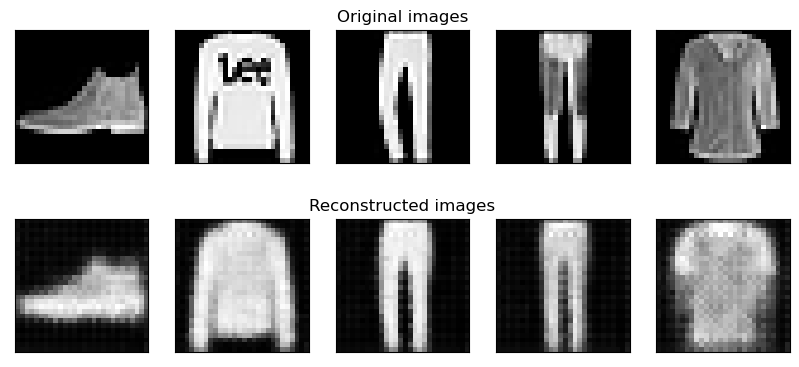

	 partial train loss (single batch): 7623.529297
	 partial train loss (single batch): 7334.833008
	 partial train loss (single batch): 7590.811523
	 partial train loss (single batch): 7756.895996
	 partial train loss (single batch): 7182.514160
	 partial train loss (single batch): 7392.101562
	 partial train loss (single batch): 7648.276855
	 partial train loss (single batch): 7494.666992
	 partial train loss (single batch): 7202.671875
	 partial train loss (single batch): 7124.288086
	 partial train loss (single batch): 7337.155273
	 partial train loss (single batch): 7409.840820
	 partial train loss (single batch): 7500.702148
	 partial train loss (single batch): 7435.690430
	 partial train loss (single batch): 7475.823242
	 partial train loss (single batch): 7218.670898
	 partial train loss (single batch): 7646.057617
	 partial train loss (single batch): 7443.654297
	 partial train loss (single batch): 7210.311523
	 partial train loss (single batch): 7340.729492
	 partial train loss

	 partial train loss (single batch): 7100.376465
	 partial train loss (single batch): 6949.995117
	 partial train loss (single batch): 7178.374512
	 partial train loss (single batch): 7224.334961
	 partial train loss (single batch): 7151.663574
	 partial train loss (single batch): 7231.679688
	 partial train loss (single batch): 7228.746094
	 partial train loss (single batch): 7101.457031
	 partial train loss (single batch): 7206.151367
	 partial train loss (single batch): 7018.131348
	 partial train loss (single batch): 7335.840820
	 partial train loss (single batch): 6899.414062
	 partial train loss (single batch): 7211.716797
	 partial train loss (single batch): 6953.105469
	 partial train loss (single batch): 7140.696289
	 partial train loss (single batch): 7133.062500
	 partial train loss (single batch): 7186.448242
	 partial train loss (single batch): 7250.377441
	 partial train loss (single batch): 6978.593262
	 partial train loss (single batch): 3630.201904

 EPOCH 5/50 	 train

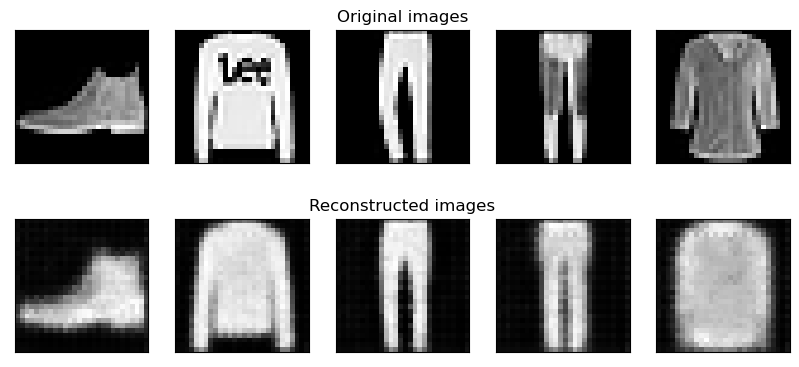

	 partial train loss (single batch): 7325.629883
	 partial train loss (single batch): 7142.041992
	 partial train loss (single batch): 7392.989746
	 partial train loss (single batch): 7603.058594
	 partial train loss (single batch): 6966.782715
	 partial train loss (single batch): 7184.940430
	 partial train loss (single batch): 7468.291504
	 partial train loss (single batch): 7239.494141
	 partial train loss (single batch): 6980.076172
	 partial train loss (single batch): 6929.428711
	 partial train loss (single batch): 7147.585449
	 partial train loss (single batch): 7212.032715
	 partial train loss (single batch): 7304.009766
	 partial train loss (single batch): 7173.456055
	 partial train loss (single batch): 7297.771484
	 partial train loss (single batch): 7022.806641
	 partial train loss (single batch): 7488.544922
	 partial train loss (single batch): 7290.668945
	 partial train loss (single batch): 6973.969727
	 partial train loss (single batch): 7148.541992
	 partial train loss

	 partial train loss (single batch): 6972.740234
	 partial train loss (single batch): 6912.763672
	 partial train loss (single batch): 7052.469727
	 partial train loss (single batch): 7143.662598
	 partial train loss (single batch): 7061.338379
	 partial train loss (single batch): 7145.914551
	 partial train loss (single batch): 7172.173828
	 partial train loss (single batch): 7041.734375
	 partial train loss (single batch): 7111.416992
	 partial train loss (single batch): 6928.294922
	 partial train loss (single batch): 7289.516602
	 partial train loss (single batch): 6836.939453
	 partial train loss (single batch): 7091.203125
	 partial train loss (single batch): 6913.041992
	 partial train loss (single batch): 7050.329102
	 partial train loss (single batch): 6987.963379
	 partial train loss (single batch): 7080.639648
	 partial train loss (single batch): 7118.983887
	 partial train loss (single batch): 6888.041992
	 partial train loss (single batch): 3601.595703

 EPOCH 6/50 	 train

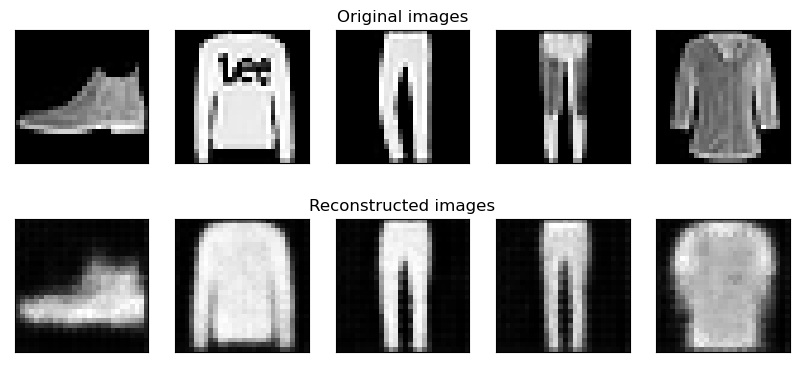

	 partial train loss (single batch): 7239.109863
	 partial train loss (single batch): 7078.854492
	 partial train loss (single batch): 7332.723145
	 partial train loss (single batch): 7461.459473
	 partial train loss (single batch): 6892.252930
	 partial train loss (single batch): 7043.518555
	 partial train loss (single batch): 7364.976562
	 partial train loss (single batch): 7117.796875
	 partial train loss (single batch): 6909.930664
	 partial train loss (single batch): 6873.783203
	 partial train loss (single batch): 7008.824219
	 partial train loss (single batch): 7101.086914
	 partial train loss (single batch): 7131.034180
	 partial train loss (single batch): 6975.754883
	 partial train loss (single batch): 7240.296387
	 partial train loss (single batch): 6914.131836
	 partial train loss (single batch): 7336.242676
	 partial train loss (single batch): 7239.856934
	 partial train loss (single batch): 6900.290039
	 partial train loss (single batch): 7102.706055
	 partial train loss

	 partial train loss (single batch): 6996.191895
	 partial train loss (single batch): 6764.413086
	 partial train loss (single batch): 7001.577637
	 partial train loss (single batch): 7031.135742
	 partial train loss (single batch): 6957.169922
	 partial train loss (single batch): 7054.873047
	 partial train loss (single batch): 7031.126953
	 partial train loss (single batch): 6815.706543
	 partial train loss (single batch): 7059.644531
	 partial train loss (single batch): 6923.754883
	 partial train loss (single batch): 7202.205078
	 partial train loss (single batch): 6753.724609
	 partial train loss (single batch): 6957.296875
	 partial train loss (single batch): 6718.572754
	 partial train loss (single batch): 6934.343750
	 partial train loss (single batch): 6923.126953
	 partial train loss (single batch): 7008.685059
	 partial train loss (single batch): 7050.782227
	 partial train loss (single batch): 6799.999023
	 partial train loss (single batch): 3517.989014

 EPOCH 7/50 	 train

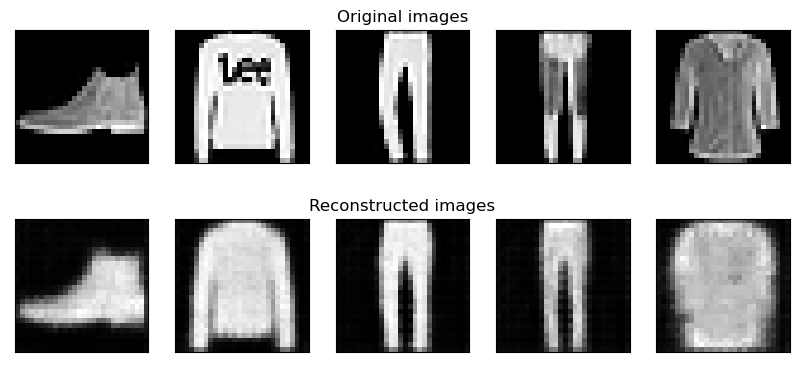

	 partial train loss (single batch): 7147.659668
	 partial train loss (single batch): 6953.199219
	 partial train loss (single batch): 7259.270508
	 partial train loss (single batch): 7368.751465
	 partial train loss (single batch): 6778.000977
	 partial train loss (single batch): 6926.539062
	 partial train loss (single batch): 7291.907715
	 partial train loss (single batch): 7020.170898
	 partial train loss (single batch): 6805.783203
	 partial train loss (single batch): 6707.947266
	 partial train loss (single batch): 6931.749023
	 partial train loss (single batch): 7048.140137
	 partial train loss (single batch): 7184.271484
	 partial train loss (single batch): 6913.513184
	 partial train loss (single batch): 7110.426758
	 partial train loss (single batch): 6940.628906
	 partial train loss (single batch): 7292.101562
	 partial train loss (single batch): 7120.764648
	 partial train loss (single batch): 6748.639648
	 partial train loss (single batch): 7073.537109
	 partial train loss

	 partial train loss (single batch): 6880.694336
	 partial train loss (single batch): 6723.986816
	 partial train loss (single batch): 6883.623047
	 partial train loss (single batch): 6921.217773
	 partial train loss (single batch): 6963.659668
	 partial train loss (single batch): 6961.597656
	 partial train loss (single batch): 7055.735352
	 partial train loss (single batch): 6840.197266
	 partial train loss (single batch): 6926.398438
	 partial train loss (single batch): 6789.712891
	 partial train loss (single batch): 7136.283691
	 partial train loss (single batch): 6704.392090
	 partial train loss (single batch): 7012.662598
	 partial train loss (single batch): 6709.268066
	 partial train loss (single batch): 6834.467773
	 partial train loss (single batch): 6880.936035
	 partial train loss (single batch): 6895.333984
	 partial train loss (single batch): 6986.494141
	 partial train loss (single batch): 6836.924805
	 partial train loss (single batch): 3513.172363

 EPOCH 8/50 	 train

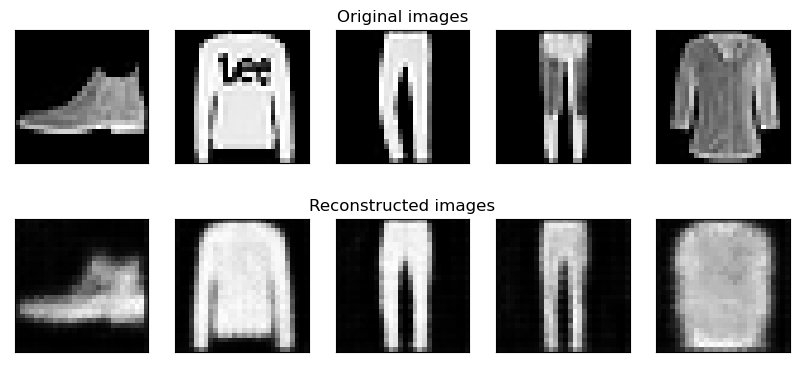

	 partial train loss (single batch): 7115.151855
	 partial train loss (single batch): 6915.588867
	 partial train loss (single batch): 7140.572266
	 partial train loss (single batch): 7274.832031
	 partial train loss (single batch): 6738.413086
	 partial train loss (single batch): 6862.624512
	 partial train loss (single batch): 7208.892578
	 partial train loss (single batch): 6990.106445
	 partial train loss (single batch): 6760.020020
	 partial train loss (single batch): 6691.809082
	 partial train loss (single batch): 6938.233398
	 partial train loss (single batch): 6995.706055
	 partial train loss (single batch): 6980.599609
	 partial train loss (single batch): 6911.306152
	 partial train loss (single batch): 7106.704102
	 partial train loss (single batch): 6839.798828
	 partial train loss (single batch): 7244.058594
	 partial train loss (single batch): 7018.912598
	 partial train loss (single batch): 6740.461914
	 partial train loss (single batch): 6869.962891
	 partial train loss

	 partial train loss (single batch): 6894.118164
	 partial train loss (single batch): 6998.505859
	 partial train loss (single batch): 6822.481445
	 partial train loss (single batch): 6892.736328
	 partial train loss (single batch): 6736.273438
	 partial train loss (single batch): 7148.218750
	 partial train loss (single batch): 6619.483398
	 partial train loss (single batch): 6909.886719
	 partial train loss (single batch): 6690.559082
	 partial train loss (single batch): 6791.267578
	 partial train loss (single batch): 6856.784180
	 partial train loss (single batch): 6826.532227
	 partial train loss (single batch): 6963.186523
	 partial train loss (single batch): 6732.462402
	 partial train loss (single batch): 3499.758057

 EPOCH 9/50 	 train loss 27.039 	 val loss 27.108


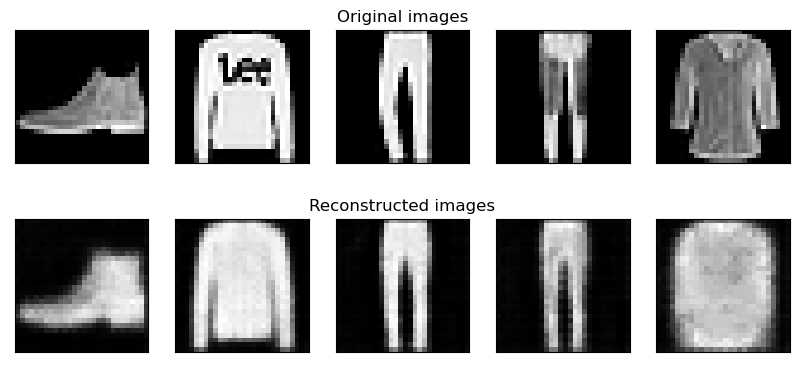

	 partial train loss (single batch): 7112.485352
	 partial train loss (single batch): 6901.774902
	 partial train loss (single batch): 7132.206055
	 partial train loss (single batch): 7192.040039
	 partial train loss (single batch): 6640.998047
	 partial train loss (single batch): 6838.056641
	 partial train loss (single batch): 7232.421875
	 partial train loss (single batch): 6985.215820
	 partial train loss (single batch): 6735.034668
	 partial train loss (single batch): 6671.045898
	 partial train loss (single batch): 6815.623535
	 partial train loss (single batch): 6973.726074
	 partial train loss (single batch): 7053.008789
	 partial train loss (single batch): 6847.874023
	 partial train loss (single batch): 7086.062500
	 partial train loss (single batch): 6861.996582
	 partial train loss (single batch): 7172.136719
	 partial train loss (single batch): 6952.251465
	 partial train loss (single batch): 6718.842773
	 partial train loss (single batch): 6931.625977
	 partial train loss

	 partial train loss (single batch): 6817.343750
	 partial train loss (single batch): 6639.550293
	 partial train loss (single batch): 6802.777832
	 partial train loss (single batch): 6799.109863
	 partial train loss (single batch): 6766.191406
	 partial train loss (single batch): 6899.673340
	 partial train loss (single batch): 6882.113281
	 partial train loss (single batch): 6840.404297
	 partial train loss (single batch): 6864.826172
	 partial train loss (single batch): 6713.553711
	 partial train loss (single batch): 7062.811523
	 partial train loss (single batch): 6656.633789
	 partial train loss (single batch): 6843.065430
	 partial train loss (single batch): 6677.697266
	 partial train loss (single batch): 6739.390625
	 partial train loss (single batch): 6785.523438
	 partial train loss (single batch): 6827.638672
	 partial train loss (single batch): 6897.985352
	 partial train loss (single batch): 6745.213867
	 partial train loss (single batch): 3540.000488

 EPOCH 10/50 	 trai

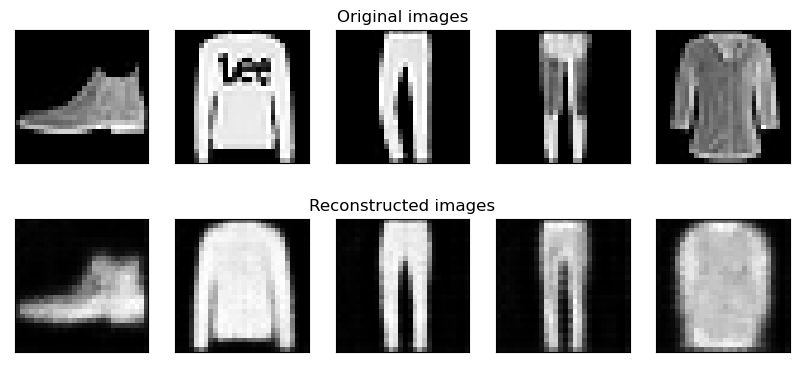

	 partial train loss (single batch): 7051.303711
	 partial train loss (single batch): 6855.375000
	 partial train loss (single batch): 7071.823242
	 partial train loss (single batch): 7291.930664
	 partial train loss (single batch): 6677.061523
	 partial train loss (single batch): 6817.401855
	 partial train loss (single batch): 7100.548828
	 partial train loss (single batch): 6907.996582
	 partial train loss (single batch): 6726.667480
	 partial train loss (single batch): 6662.929688
	 partial train loss (single batch): 6756.689453
	 partial train loss (single batch): 6853.867676
	 partial train loss (single batch): 6956.188477
	 partial train loss (single batch): 6857.046875
	 partial train loss (single batch): 7032.610352
	 partial train loss (single batch): 6731.146973
	 partial train loss (single batch): 7103.903809
	 partial train loss (single batch): 6903.418457
	 partial train loss (single batch): 6667.206055
	 partial train loss (single batch): 6866.935547
	 partial train loss

	 partial train loss (single batch): 6799.533203
	 partial train loss (single batch): 6671.756836
	 partial train loss (single batch): 6704.714844
	 partial train loss (single batch): 6828.658203
	 partial train loss (single batch): 6793.351074
	 partial train loss (single batch): 6904.043457
	 partial train loss (single batch): 6912.129883
	 partial train loss (single batch): 6738.978516
	 partial train loss (single batch): 6852.583984
	 partial train loss (single batch): 6728.427246
	 partial train loss (single batch): 7094.874023
	 partial train loss (single batch): 6554.237305
	 partial train loss (single batch): 6859.109375
	 partial train loss (single batch): 6630.236816
	 partial train loss (single batch): 6699.389648
	 partial train loss (single batch): 6695.238281
	 partial train loss (single batch): 6802.317383
	 partial train loss (single batch): 6865.808594
	 partial train loss (single batch): 6550.083984
	 partial train loss (single batch): 3486.965820

 EPOCH 11/50 	 trai

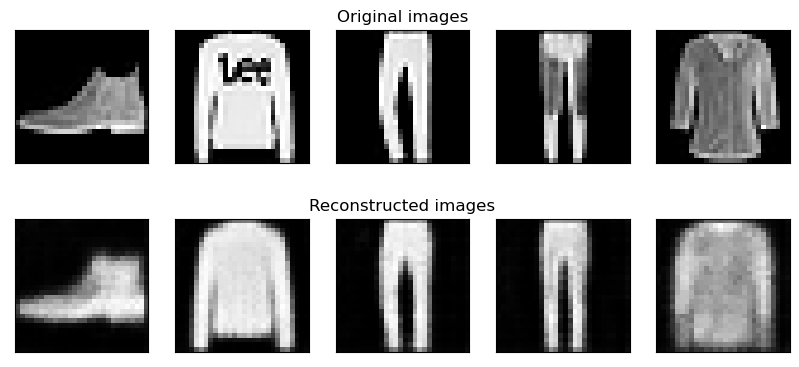

	 partial train loss (single batch): 7039.720215
	 partial train loss (single batch): 6849.897461
	 partial train loss (single batch): 6981.937012
	 partial train loss (single batch): 7209.397461
	 partial train loss (single batch): 6551.745605
	 partial train loss (single batch): 6822.856445
	 partial train loss (single batch): 7129.409180
	 partial train loss (single batch): 6825.483398
	 partial train loss (single batch): 6707.638672
	 partial train loss (single batch): 6642.120117
	 partial train loss (single batch): 6764.500000
	 partial train loss (single batch): 6894.728027
	 partial train loss (single batch): 6934.294922
	 partial train loss (single batch): 6781.386719
	 partial train loss (single batch): 6971.884766
	 partial train loss (single batch): 6711.360352
	 partial train loss (single batch): 7165.874023
	 partial train loss (single batch): 6919.316406
	 partial train loss (single batch): 6648.079590
	 partial train loss (single batch): 6818.739746
	 partial train loss

	 partial train loss (single batch): 6764.085938
	 partial train loss (single batch): 6660.229004
	 partial train loss (single batch): 6789.121582
	 partial train loss (single batch): 6853.548340
	 partial train loss (single batch): 6772.119141
	 partial train loss (single batch): 6843.729980
	 partial train loss (single batch): 6903.764160
	 partial train loss (single batch): 6697.925781
	 partial train loss (single batch): 6787.669922
	 partial train loss (single batch): 6693.903809
	 partial train loss (single batch): 7009.635742
	 partial train loss (single batch): 6568.307617
	 partial train loss (single batch): 6788.081055
	 partial train loss (single batch): 6583.794922
	 partial train loss (single batch): 6646.141602
	 partial train loss (single batch): 6721.632324
	 partial train loss (single batch): 6769.423828
	 partial train loss (single batch): 6820.939941
	 partial train loss (single batch): 6588.522461
	 partial train loss (single batch): 3475.269043

 EPOCH 12/50 	 trai

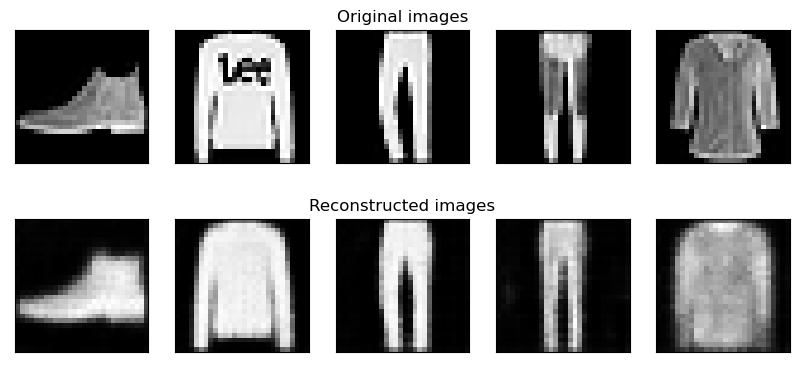

	 partial train loss (single batch): 6996.664062
	 partial train loss (single batch): 6864.339844
	 partial train loss (single batch): 7058.514160
	 partial train loss (single batch): 7109.987305
	 partial train loss (single batch): 6593.715332
	 partial train loss (single batch): 6721.701660
	 partial train loss (single batch): 7104.658203
	 partial train loss (single batch): 6769.407227
	 partial train loss (single batch): 6666.634277
	 partial train loss (single batch): 6608.501953
	 partial train loss (single batch): 6683.935547
	 partial train loss (single batch): 6798.957031
	 partial train loss (single batch): 6913.027344
	 partial train loss (single batch): 6795.695312
	 partial train loss (single batch): 7020.607910
	 partial train loss (single batch): 6741.693359
	 partial train loss (single batch): 7150.490723
	 partial train loss (single batch): 6882.933594
	 partial train loss (single batch): 6573.257812
	 partial train loss (single batch): 6847.834473
	 partial train loss

	 partial train loss (single batch): 6802.796875
	 partial train loss (single batch): 6637.967773
	 partial train loss (single batch): 6757.882324
	 partial train loss (single batch): 6870.250977
	 partial train loss (single batch): 6786.424805
	 partial train loss (single batch): 6862.671875
	 partial train loss (single batch): 6859.270508
	 partial train loss (single batch): 6730.688965
	 partial train loss (single batch): 6794.242188
	 partial train loss (single batch): 6680.276855
	 partial train loss (single batch): 6962.555176
	 partial train loss (single batch): 6497.956543
	 partial train loss (single batch): 6724.028809
	 partial train loss (single batch): 6659.463867
	 partial train loss (single batch): 6636.036133
	 partial train loss (single batch): 6704.423340
	 partial train loss (single batch): 6746.041016
	 partial train loss (single batch): 6841.985352
	 partial train loss (single batch): 6554.704102
	 partial train loss (single batch): 3458.651367

 EPOCH 13/50 	 trai

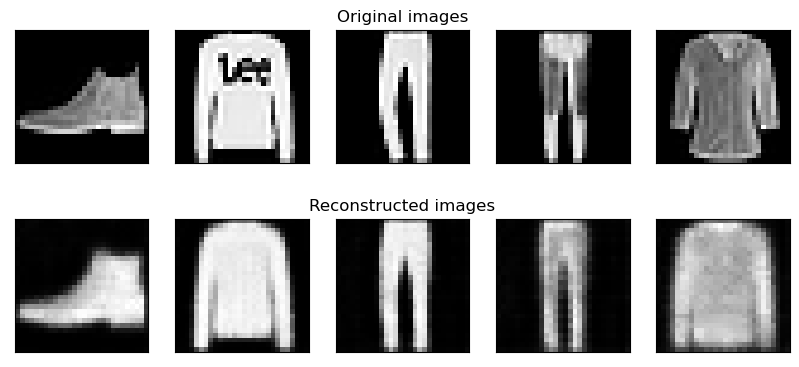

	 partial train loss (single batch): 6975.097168
	 partial train loss (single batch): 6858.088867
	 partial train loss (single batch): 6961.160156
	 partial train loss (single batch): 7144.086914
	 partial train loss (single batch): 6568.087891
	 partial train loss (single batch): 6698.562012
	 partial train loss (single batch): 7027.159180
	 partial train loss (single batch): 6868.476074
	 partial train loss (single batch): 6614.503418
	 partial train loss (single batch): 6565.105469
	 partial train loss (single batch): 6683.649414
	 partial train loss (single batch): 6831.681641
	 partial train loss (single batch): 6856.962402
	 partial train loss (single batch): 6754.009277
	 partial train loss (single batch): 6866.346680
	 partial train loss (single batch): 6817.146973
	 partial train loss (single batch): 7041.657715
	 partial train loss (single batch): 6924.963379
	 partial train loss (single batch): 6555.394043
	 partial train loss (single batch): 6797.326172
	 partial train loss

	 partial train loss (single batch): 6744.619141
	 partial train loss (single batch): 6664.250000
	 partial train loss (single batch): 6739.378418
	 partial train loss (single batch): 6781.000000
	 partial train loss (single batch): 6763.666992
	 partial train loss (single batch): 6759.812988
	 partial train loss (single batch): 6800.018555
	 partial train loss (single batch): 6716.608398
	 partial train loss (single batch): 6809.628418
	 partial train loss (single batch): 6623.110352
	 partial train loss (single batch): 6898.271484
	 partial train loss (single batch): 6563.340820
	 partial train loss (single batch): 6740.330566
	 partial train loss (single batch): 6554.375000
	 partial train loss (single batch): 6697.427246
	 partial train loss (single batch): 6820.000488
	 partial train loss (single batch): 6777.747070
	 partial train loss (single batch): 6720.185547
	 partial train loss (single batch): 6610.388184
	 partial train loss (single batch): 3481.768066

 EPOCH 14/50 	 trai

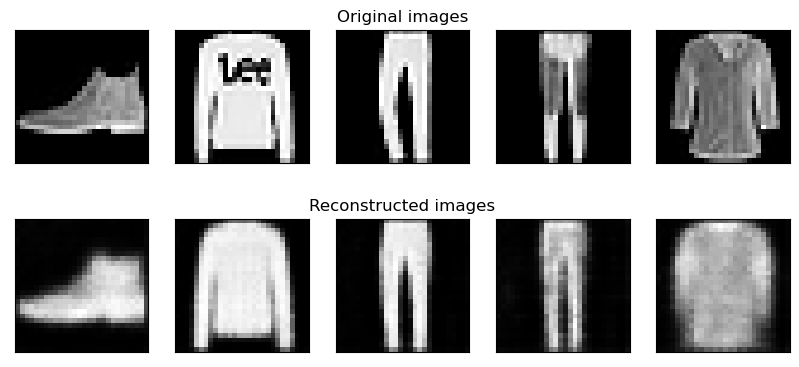

	 partial train loss (single batch): 7015.183105
	 partial train loss (single batch): 6727.377930
	 partial train loss (single batch): 6994.398926
	 partial train loss (single batch): 7169.142578
	 partial train loss (single batch): 6541.643555
	 partial train loss (single batch): 6719.493164
	 partial train loss (single batch): 7036.922852
	 partial train loss (single batch): 6842.321289
	 partial train loss (single batch): 6557.673828
	 partial train loss (single batch): 6494.697266
	 partial train loss (single batch): 6671.747559
	 partial train loss (single batch): 6788.422363
	 partial train loss (single batch): 6864.250000
	 partial train loss (single batch): 6810.630859
	 partial train loss (single batch): 6954.862793
	 partial train loss (single batch): 6701.455078
	 partial train loss (single batch): 7072.800781
	 partial train loss (single batch): 6901.556152
	 partial train loss (single batch): 6564.343750
	 partial train loss (single batch): 6731.093262
	 partial train loss

	 partial train loss (single batch): 6739.947754
	 partial train loss (single batch): 6544.904297
	 partial train loss (single batch): 6794.335449
	 partial train loss (single batch): 6731.335449
	 partial train loss (single batch): 6722.272461
	 partial train loss (single batch): 6745.392090
	 partial train loss (single batch): 6818.883789
	 partial train loss (single batch): 6717.786133
	 partial train loss (single batch): 6754.072754
	 partial train loss (single batch): 6602.466797
	 partial train loss (single batch): 6922.950195
	 partial train loss (single batch): 6513.006348
	 partial train loss (single batch): 6736.166016
	 partial train loss (single batch): 6466.663086
	 partial train loss (single batch): 6632.951172
	 partial train loss (single batch): 6752.978516
	 partial train loss (single batch): 6655.904297
	 partial train loss (single batch): 6758.486328
	 partial train loss (single batch): 6588.284180
	 partial train loss (single batch): 3456.548828

 EPOCH 15/50 	 trai

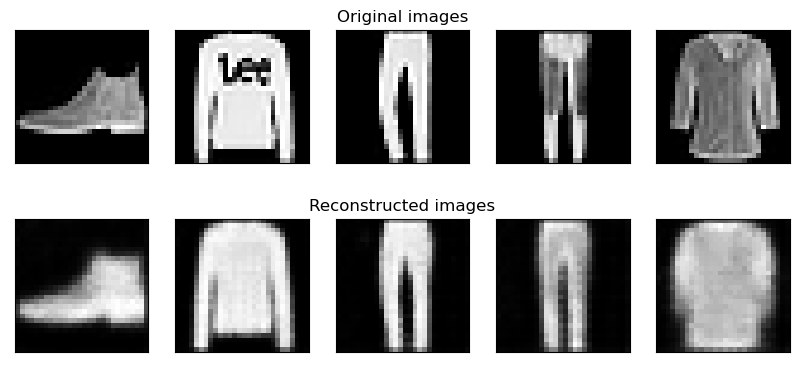

	 partial train loss (single batch): 6925.292969
	 partial train loss (single batch): 6778.104492
	 partial train loss (single batch): 6981.375488
	 partial train loss (single batch): 7133.612793
	 partial train loss (single batch): 6445.579102
	 partial train loss (single batch): 6660.151367
	 partial train loss (single batch): 7107.252930
	 partial train loss (single batch): 6735.484375
	 partial train loss (single batch): 6549.207031
	 partial train loss (single batch): 6549.216797
	 partial train loss (single batch): 6613.777832
	 partial train loss (single batch): 6860.152832
	 partial train loss (single batch): 6827.894531
	 partial train loss (single batch): 6733.233887
	 partial train loss (single batch): 6879.296875
	 partial train loss (single batch): 6587.944824
	 partial train loss (single batch): 6984.322266
	 partial train loss (single batch): 6885.196777
	 partial train loss (single batch): 6585.101562
	 partial train loss (single batch): 6827.541992
	 partial train loss

	 partial train loss (single batch): 6677.754395
	 partial train loss (single batch): 6560.397949
	 partial train loss (single batch): 6707.514648
	 partial train loss (single batch): 6738.959961
	 partial train loss (single batch): 6686.486328
	 partial train loss (single batch): 6761.128418
	 partial train loss (single batch): 6812.733398
	 partial train loss (single batch): 6653.760742
	 partial train loss (single batch): 6791.180176
	 partial train loss (single batch): 6619.327148
	 partial train loss (single batch): 6888.313477
	 partial train loss (single batch): 6481.233398
	 partial train loss (single batch): 6680.391602
	 partial train loss (single batch): 6490.111328
	 partial train loss (single batch): 6684.909180
	 partial train loss (single batch): 6717.847168
	 partial train loss (single batch): 6647.581055
	 partial train loss (single batch): 6753.898926
	 partial train loss (single batch): 6553.934570
	 partial train loss (single batch): 3468.271240

 EPOCH 16/50 	 trai

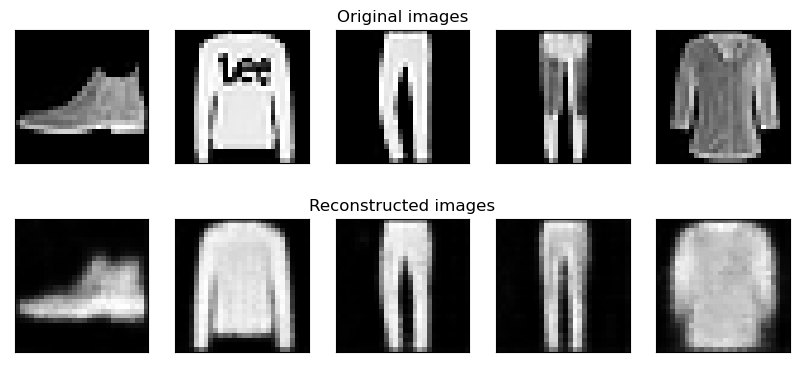

	 partial train loss (single batch): 6931.393555
	 partial train loss (single batch): 6718.858887
	 partial train loss (single batch): 6959.221680
	 partial train loss (single batch): 7052.774902
	 partial train loss (single batch): 6452.841797
	 partial train loss (single batch): 6649.298828
	 partial train loss (single batch): 6964.815430
	 partial train loss (single batch): 6756.263184
	 partial train loss (single batch): 6592.199707
	 partial train loss (single batch): 6426.653320
	 partial train loss (single batch): 6592.653809
	 partial train loss (single batch): 6718.715820
	 partial train loss (single batch): 6786.783203
	 partial train loss (single batch): 6695.968750
	 partial train loss (single batch): 6871.821289
	 partial train loss (single batch): 6591.046875
	 partial train loss (single batch): 7025.602539
	 partial train loss (single batch): 6858.658203
	 partial train loss (single batch): 6480.801758
	 partial train loss (single batch): 6749.250000
	 partial train loss

	 partial train loss (single batch): 6698.562500
	 partial train loss (single batch): 6527.861328
	 partial train loss (single batch): 6690.417969
	 partial train loss (single batch): 6702.782227
	 partial train loss (single batch): 6681.757812
	 partial train loss (single batch): 6736.368652
	 partial train loss (single batch): 6827.045898
	 partial train loss (single batch): 6601.256836
	 partial train loss (single batch): 6783.400391
	 partial train loss (single batch): 6609.146484
	 partial train loss (single batch): 6933.922852
	 partial train loss (single batch): 6465.928223
	 partial train loss (single batch): 6710.289062
	 partial train loss (single batch): 6529.390625
	 partial train loss (single batch): 6607.565430
	 partial train loss (single batch): 6657.125000
	 partial train loss (single batch): 6645.534180
	 partial train loss (single batch): 6722.532227
	 partial train loss (single batch): 6488.363770
	 partial train loss (single batch): 3457.277344

 EPOCH 17/50 	 trai

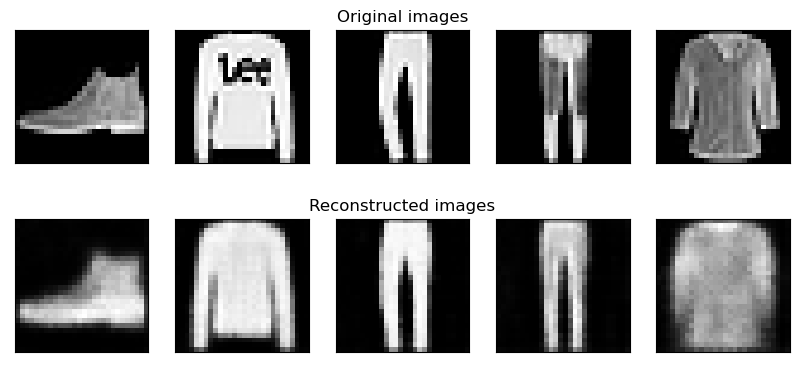

	 partial train loss (single batch): 6963.363281
	 partial train loss (single batch): 6705.465820
	 partial train loss (single batch): 6919.416992
	 partial train loss (single batch): 7075.688965
	 partial train loss (single batch): 6494.753418
	 partial train loss (single batch): 6605.893066
	 partial train loss (single batch): 6990.056152
	 partial train loss (single batch): 6716.719238
	 partial train loss (single batch): 6529.996094
	 partial train loss (single batch): 6464.538574
	 partial train loss (single batch): 6627.493164
	 partial train loss (single batch): 6734.881348
	 partial train loss (single batch): 6773.153320
	 partial train loss (single batch): 6661.540527
	 partial train loss (single batch): 6827.157715
	 partial train loss (single batch): 6593.172852
	 partial train loss (single batch): 7057.634766
	 partial train loss (single batch): 6771.503418
	 partial train loss (single batch): 6579.081543
	 partial train loss (single batch): 6717.021484
	 partial train loss

	 partial train loss (single batch): 6639.369141
	 partial train loss (single batch): 6538.774414
	 partial train loss (single batch): 6683.691895
	 partial train loss (single batch): 6701.373047
	 partial train loss (single batch): 6754.924316
	 partial train loss (single batch): 6753.569336
	 partial train loss (single batch): 6816.029297
	 partial train loss (single batch): 6629.227539
	 partial train loss (single batch): 6742.866211
	 partial train loss (single batch): 6518.914062
	 partial train loss (single batch): 6949.630859
	 partial train loss (single batch): 6475.953125
	 partial train loss (single batch): 6702.308594
	 partial train loss (single batch): 6521.708496
	 partial train loss (single batch): 6542.948242
	 partial train loss (single batch): 6692.487305
	 partial train loss (single batch): 6662.548340
	 partial train loss (single batch): 6673.856445
	 partial train loss (single batch): 6505.779785
	 partial train loss (single batch): 3395.304199

 EPOCH 18/50 	 trai

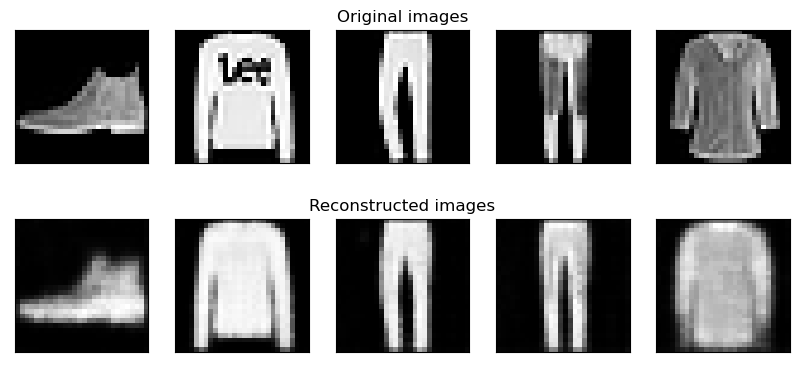

	 partial train loss (single batch): 6825.129883
	 partial train loss (single batch): 6709.151855
	 partial train loss (single batch): 6917.334473
	 partial train loss (single batch): 7126.317871
	 partial train loss (single batch): 6506.658203
	 partial train loss (single batch): 6636.541016
	 partial train loss (single batch): 6993.072266
	 partial train loss (single batch): 6729.796875
	 partial train loss (single batch): 6503.222656
	 partial train loss (single batch): 6443.512695
	 partial train loss (single batch): 6659.002441
	 partial train loss (single batch): 6793.440430
	 partial train loss (single batch): 6778.943359
	 partial train loss (single batch): 6625.294434
	 partial train loss (single batch): 6881.459961
	 partial train loss (single batch): 6679.439941
	 partial train loss (single batch): 6990.791504
	 partial train loss (single batch): 6799.338867
	 partial train loss (single batch): 6533.440430
	 partial train loss (single batch): 6723.688477
	 partial train loss

	 partial train loss (single batch): 6644.053711
	 partial train loss (single batch): 6595.662598
	 partial train loss (single batch): 6679.300293
	 partial train loss (single batch): 6677.627441
	 partial train loss (single batch): 6650.835938
	 partial train loss (single batch): 6734.664062
	 partial train loss (single batch): 6743.188477
	 partial train loss (single batch): 6607.666016
	 partial train loss (single batch): 6688.105957
	 partial train loss (single batch): 6614.086914
	 partial train loss (single batch): 6881.906250
	 partial train loss (single batch): 6402.793945
	 partial train loss (single batch): 6601.989258
	 partial train loss (single batch): 6470.541992
	 partial train loss (single batch): 6538.165039
	 partial train loss (single batch): 6690.571289
	 partial train loss (single batch): 6636.992676
	 partial train loss (single batch): 6728.382812
	 partial train loss (single batch): 6386.405762
	 partial train loss (single batch): 3394.922363

 EPOCH 19/50 	 trai

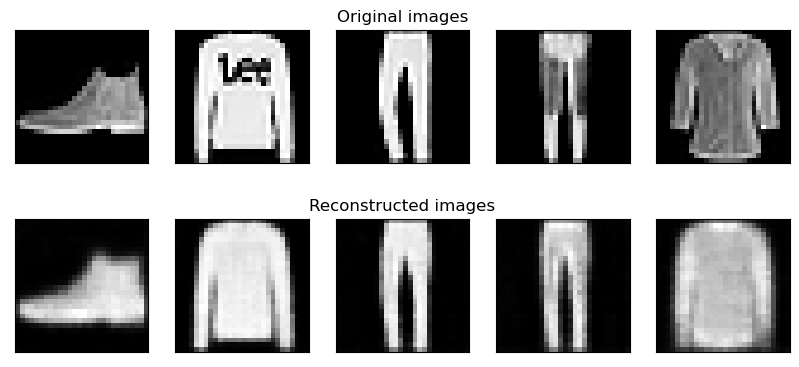

	 partial train loss (single batch): 6777.999512
	 partial train loss (single batch): 6669.523438
	 partial train loss (single batch): 6924.504395
	 partial train loss (single batch): 7033.504883
	 partial train loss (single batch): 6470.656250
	 partial train loss (single batch): 6588.540527
	 partial train loss (single batch): 6952.023438
	 partial train loss (single batch): 6620.259766
	 partial train loss (single batch): 6486.300781
	 partial train loss (single batch): 6433.269531
	 partial train loss (single batch): 6585.601074
	 partial train loss (single batch): 6704.823730
	 partial train loss (single batch): 6719.565918
	 partial train loss (single batch): 6636.354004
	 partial train loss (single batch): 6894.748047
	 partial train loss (single batch): 6584.442383
	 partial train loss (single batch): 6982.024902
	 partial train loss (single batch): 6828.193359
	 partial train loss (single batch): 6465.866211
	 partial train loss (single batch): 6636.945801
	 partial train loss

	 partial train loss (single batch): 6710.716797
	 partial train loss (single batch): 6492.600586
	 partial train loss (single batch): 6634.706055
	 partial train loss (single batch): 6707.185059
	 partial train loss (single batch): 6719.555664
	 partial train loss (single batch): 6748.335938
	 partial train loss (single batch): 6755.612793
	 partial train loss (single batch): 6608.672852
	 partial train loss (single batch): 6690.631836
	 partial train loss (single batch): 6583.989746
	 partial train loss (single batch): 6860.076172
	 partial train loss (single batch): 6453.284180
	 partial train loss (single batch): 6664.459473
	 partial train loss (single batch): 6456.939453
	 partial train loss (single batch): 6540.732910
	 partial train loss (single batch): 6709.485352
	 partial train loss (single batch): 6624.512695
	 partial train loss (single batch): 6691.504883
	 partial train loss (single batch): 6461.357422
	 partial train loss (single batch): 3437.645508

 EPOCH 20/50 	 trai

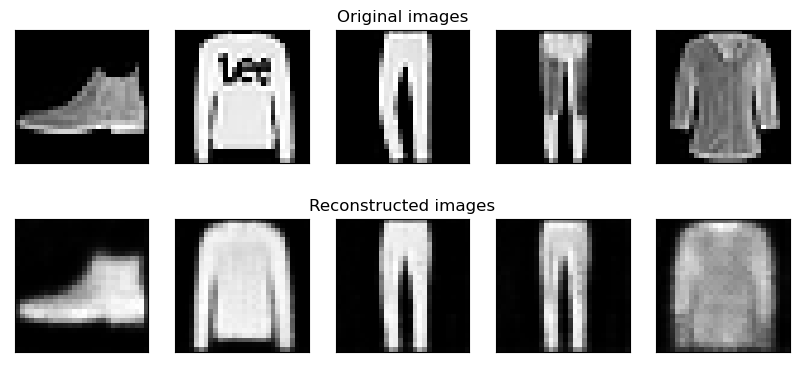

	 partial train loss (single batch): 6878.837891
	 partial train loss (single batch): 6674.045898
	 partial train loss (single batch): 6875.961914
	 partial train loss (single batch): 7104.958984
	 partial train loss (single batch): 6443.791992
	 partial train loss (single batch): 6568.755859
	 partial train loss (single batch): 6962.447266
	 partial train loss (single batch): 6635.313477
	 partial train loss (single batch): 6497.080078
	 partial train loss (single batch): 6458.316895
	 partial train loss (single batch): 6636.719727
	 partial train loss (single batch): 6804.204102
	 partial train loss (single batch): 6755.843750
	 partial train loss (single batch): 6646.558594
	 partial train loss (single batch): 6833.687988
	 partial train loss (single batch): 6518.267578
	 partial train loss (single batch): 6993.521484
	 partial train loss (single batch): 6795.890625
	 partial train loss (single batch): 6536.703125
	 partial train loss (single batch): 6580.664551
	 partial train loss

	 partial train loss (single batch): 6615.479492
	 partial train loss (single batch): 6475.510742
	 partial train loss (single batch): 6644.718750
	 partial train loss (single batch): 6682.220215
	 partial train loss (single batch): 6703.006348
	 partial train loss (single batch): 6705.015625
	 partial train loss (single batch): 6758.071777
	 partial train loss (single batch): 6556.571289
	 partial train loss (single batch): 6682.162109
	 partial train loss (single batch): 6569.798828
	 partial train loss (single batch): 6880.931152
	 partial train loss (single batch): 6370.935547
	 partial train loss (single batch): 6646.717285
	 partial train loss (single batch): 6423.607422
	 partial train loss (single batch): 6553.430664
	 partial train loss (single batch): 6647.872559
	 partial train loss (single batch): 6658.020508
	 partial train loss (single batch): 6637.657227
	 partial train loss (single batch): 6419.397461
	 partial train loss (single batch): 3406.225098

 EPOCH 21/50 	 trai

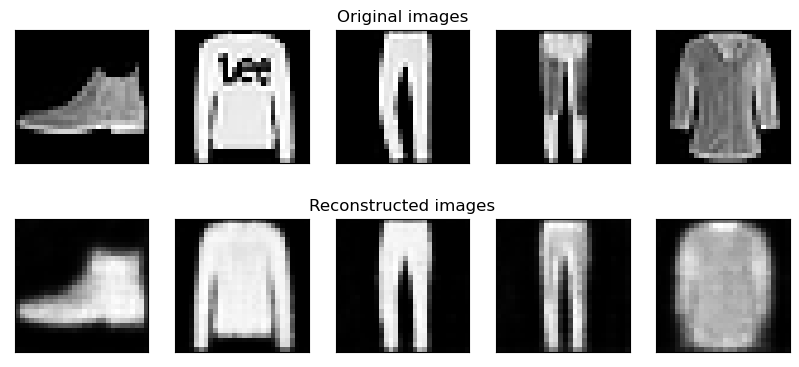

	 partial train loss (single batch): 6789.169922
	 partial train loss (single batch): 6746.256836
	 partial train loss (single batch): 6841.110352
	 partial train loss (single batch): 7048.049805
	 partial train loss (single batch): 6432.859375
	 partial train loss (single batch): 6547.127930
	 partial train loss (single batch): 6982.652832
	 partial train loss (single batch): 6609.510742
	 partial train loss (single batch): 6516.590820
	 partial train loss (single batch): 6494.376953
	 partial train loss (single batch): 6583.117676
	 partial train loss (single batch): 6674.107422
	 partial train loss (single batch): 6725.184570
	 partial train loss (single batch): 6563.095703
	 partial train loss (single batch): 6833.047852
	 partial train loss (single batch): 6601.321289
	 partial train loss (single batch): 6947.370117
	 partial train loss (single batch): 6788.865723
	 partial train loss (single batch): 6478.050781
	 partial train loss (single batch): 6668.717773
	 partial train loss

	 partial train loss (single batch): 6646.838867
	 partial train loss (single batch): 6496.742188
	 partial train loss (single batch): 6597.935059
	 partial train loss (single batch): 6631.676758
	 partial train loss (single batch): 6638.608398
	 partial train loss (single batch): 6726.958984
	 partial train loss (single batch): 6780.354492
	 partial train loss (single batch): 6572.577148
	 partial train loss (single batch): 6687.221680
	 partial train loss (single batch): 6560.285156
	 partial train loss (single batch): 6796.965820
	 partial train loss (single batch): 6378.309082
	 partial train loss (single batch): 6649.806641
	 partial train loss (single batch): 6445.561523
	 partial train loss (single batch): 6556.576172
	 partial train loss (single batch): 6610.117188
	 partial train loss (single batch): 6590.985352
	 partial train loss (single batch): 6636.207520
	 partial train loss (single batch): 6412.733887
	 partial train loss (single batch): 3419.693848

 EPOCH 22/50 	 trai

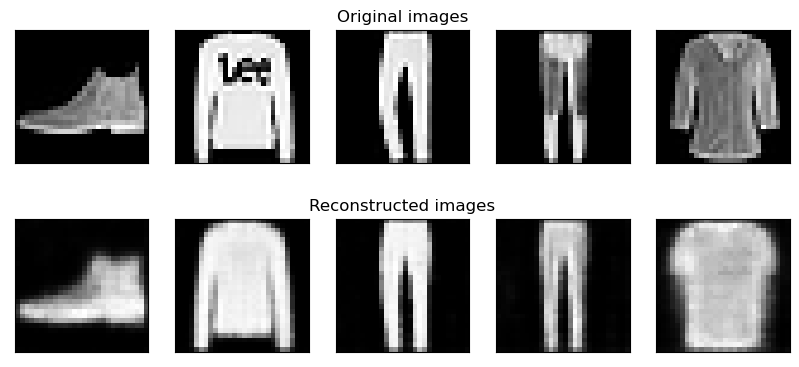

	 partial train loss (single batch): 6843.182617
	 partial train loss (single batch): 6584.594727
	 partial train loss (single batch): 6873.192383
	 partial train loss (single batch): 7000.954590
	 partial train loss (single batch): 6398.889160
	 partial train loss (single batch): 6560.593750
	 partial train loss (single batch): 6979.447266
	 partial train loss (single batch): 6586.261230
	 partial train loss (single batch): 6461.743164
	 partial train loss (single batch): 6481.753906
	 partial train loss (single batch): 6545.861328
	 partial train loss (single batch): 6654.172852
	 partial train loss (single batch): 6765.023926
	 partial train loss (single batch): 6624.747070
	 partial train loss (single batch): 6839.485352
	 partial train loss (single batch): 6559.993164
	 partial train loss (single batch): 6955.055664
	 partial train loss (single batch): 6754.377930
	 partial train loss (single batch): 6447.981934
	 partial train loss (single batch): 6672.350586
	 partial train loss

	 partial train loss (single batch): 6667.715820
	 partial train loss (single batch): 6489.275391
	 partial train loss (single batch): 6616.268066
	 partial train loss (single batch): 6595.443848
	 partial train loss (single batch): 6658.474609
	 partial train loss (single batch): 6690.594727
	 partial train loss (single batch): 6752.046875
	 partial train loss (single batch): 6608.612793
	 partial train loss (single batch): 6692.495117
	 partial train loss (single batch): 6544.755371
	 partial train loss (single batch): 6827.180664
	 partial train loss (single batch): 6377.640625
	 partial train loss (single batch): 6624.271973
	 partial train loss (single batch): 6475.201660
	 partial train loss (single batch): 6484.379395
	 partial train loss (single batch): 6623.918945
	 partial train loss (single batch): 6502.961426
	 partial train loss (single batch): 6663.428711
	 partial train loss (single batch): 6437.366211
	 partial train loss (single batch): 3434.560059

 EPOCH 23/50 	 trai

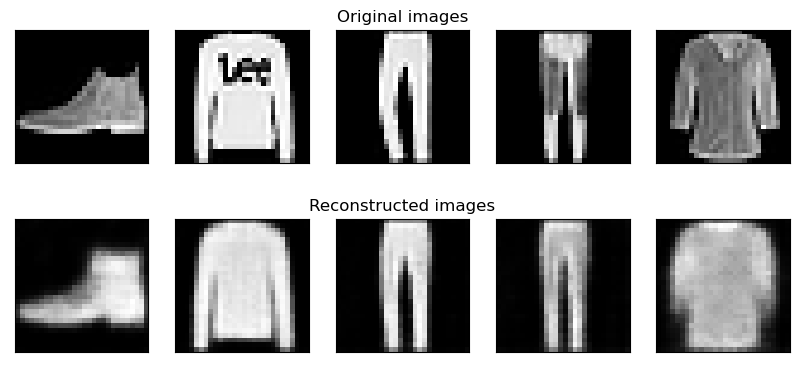

	 partial train loss (single batch): 6763.186523
	 partial train loss (single batch): 6633.803711
	 partial train loss (single batch): 6831.263672
	 partial train loss (single batch): 7056.461914
	 partial train loss (single batch): 6403.251953
	 partial train loss (single batch): 6571.867188
	 partial train loss (single batch): 6931.751465
	 partial train loss (single batch): 6545.473633
	 partial train loss (single batch): 6426.940918
	 partial train loss (single batch): 6405.252930
	 partial train loss (single batch): 6538.419922
	 partial train loss (single batch): 6698.040039
	 partial train loss (single batch): 6741.611328
	 partial train loss (single batch): 6589.235352
	 partial train loss (single batch): 6817.138672
	 partial train loss (single batch): 6571.630371
	 partial train loss (single batch): 6983.544922
	 partial train loss (single batch): 6659.983398
	 partial train loss (single batch): 6414.694336
	 partial train loss (single batch): 6566.693848
	 partial train loss

	 partial train loss (single batch): 6595.830078
	 partial train loss (single batch): 6435.509766
	 partial train loss (single batch): 6589.498047
	 partial train loss (single batch): 6624.305176
	 partial train loss (single batch): 6664.203125
	 partial train loss (single batch): 6672.824219
	 partial train loss (single batch): 6752.733398
	 partial train loss (single batch): 6549.021484
	 partial train loss (single batch): 6676.917480
	 partial train loss (single batch): 6562.378418
	 partial train loss (single batch): 6862.008789
	 partial train loss (single batch): 6404.926758
	 partial train loss (single batch): 6670.304199
	 partial train loss (single batch): 6465.281250
	 partial train loss (single batch): 6454.242188
	 partial train loss (single batch): 6562.313477
	 partial train loss (single batch): 6606.393555
	 partial train loss (single batch): 6566.417969
	 partial train loss (single batch): 6467.531250
	 partial train loss (single batch): 3385.795654

 EPOCH 24/50 	 trai

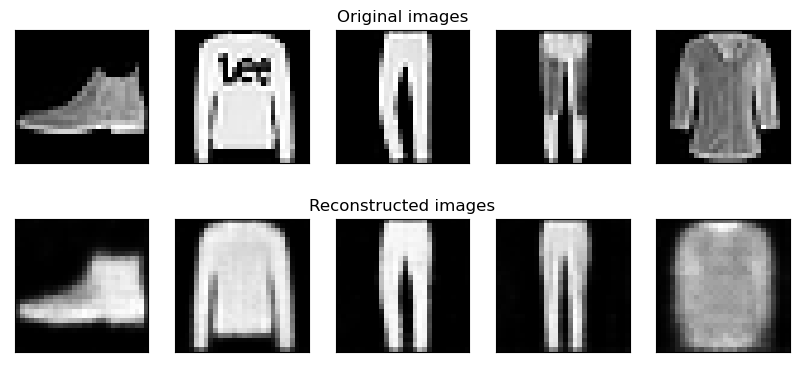

	 partial train loss (single batch): 6872.985840
	 partial train loss (single batch): 6609.683594
	 partial train loss (single batch): 6825.253418
	 partial train loss (single batch): 7028.518555
	 partial train loss (single batch): 6468.156738
	 partial train loss (single batch): 6491.153320
	 partial train loss (single batch): 7002.990723
	 partial train loss (single batch): 6599.136719
	 partial train loss (single batch): 6430.173828
	 partial train loss (single batch): 6381.434082
	 partial train loss (single batch): 6525.252441
	 partial train loss (single batch): 6729.421875
	 partial train loss (single batch): 6726.816406
	 partial train loss (single batch): 6636.049316
	 partial train loss (single batch): 6804.887207
	 partial train loss (single batch): 6498.626953
	 partial train loss (single batch): 6916.346680
	 partial train loss (single batch): 6754.998047
	 partial train loss (single batch): 6474.862305
	 partial train loss (single batch): 6601.098145
	 partial train loss

	 partial train loss (single batch): 6569.217773
	 partial train loss (single batch): 6456.815430
	 partial train loss (single batch): 6654.775879
	 partial train loss (single batch): 6611.916992
	 partial train loss (single batch): 6596.991699
	 partial train loss (single batch): 6681.749023
	 partial train loss (single batch): 6727.372559
	 partial train loss (single batch): 6557.950195
	 partial train loss (single batch): 6652.948242
	 partial train loss (single batch): 6518.094727
	 partial train loss (single batch): 6850.654297
	 partial train loss (single batch): 6384.476074
	 partial train loss (single batch): 6578.542969
	 partial train loss (single batch): 6401.077637
	 partial train loss (single batch): 6468.030762
	 partial train loss (single batch): 6625.930176
	 partial train loss (single batch): 6534.801270
	 partial train loss (single batch): 6667.266602
	 partial train loss (single batch): 6388.260742
	 partial train loss (single batch): 3342.456055

 EPOCH 25/50 	 trai

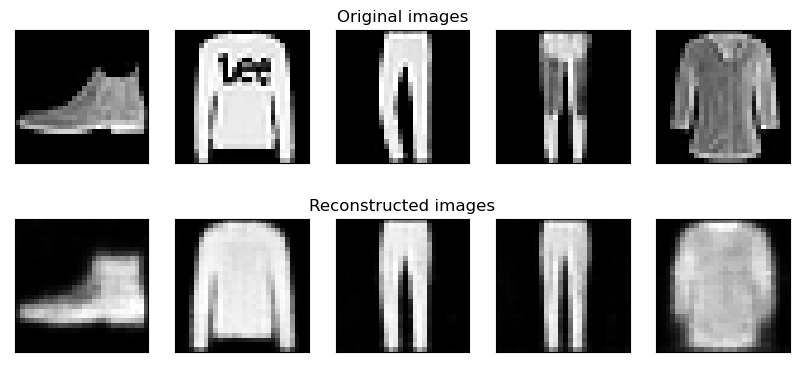

	 partial train loss (single batch): 6751.078125
	 partial train loss (single batch): 6611.328125
	 partial train loss (single batch): 6828.012207
	 partial train loss (single batch): 7029.933594
	 partial train loss (single batch): 6411.031738
	 partial train loss (single batch): 6526.482422
	 partial train loss (single batch): 6912.601562
	 partial train loss (single batch): 6591.809082
	 partial train loss (single batch): 6444.759766
	 partial train loss (single batch): 6433.153320
	 partial train loss (single batch): 6569.485352
	 partial train loss (single batch): 6656.217773
	 partial train loss (single batch): 6725.210449
	 partial train loss (single batch): 6556.194336
	 partial train loss (single batch): 6765.544922
	 partial train loss (single batch): 6478.682617
	 partial train loss (single batch): 6976.871582
	 partial train loss (single batch): 6719.574219
	 partial train loss (single batch): 6495.696289
	 partial train loss (single batch): 6568.773438
	 partial train loss

	 partial train loss (single batch): 6683.048340
	 partial train loss (single batch): 6464.156250
	 partial train loss (single batch): 6606.322754
	 partial train loss (single batch): 6611.421387
	 partial train loss (single batch): 6625.270508
	 partial train loss (single batch): 6660.007324
	 partial train loss (single batch): 6681.432617
	 partial train loss (single batch): 6522.047852
	 partial train loss (single batch): 6722.255859
	 partial train loss (single batch): 6550.782227
	 partial train loss (single batch): 6813.650391
	 partial train loss (single batch): 6330.732422
	 partial train loss (single batch): 6594.813477
	 partial train loss (single batch): 6328.192871
	 partial train loss (single batch): 6465.402344
	 partial train loss (single batch): 6583.624512
	 partial train loss (single batch): 6547.448242
	 partial train loss (single batch): 6619.203125
	 partial train loss (single batch): 6406.883789
	 partial train loss (single batch): 3357.168213

 EPOCH 26/50 	 trai

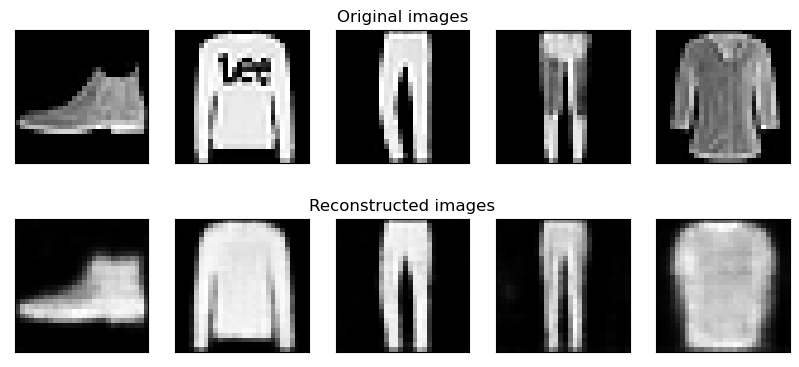

	 partial train loss (single batch): 6800.121582
	 partial train loss (single batch): 6647.175781
	 partial train loss (single batch): 6845.226074
	 partial train loss (single batch): 6994.137207
	 partial train loss (single batch): 6341.500000
	 partial train loss (single batch): 6502.936523
	 partial train loss (single batch): 6912.795898
	 partial train loss (single batch): 6521.306641
	 partial train loss (single batch): 6386.979492
	 partial train loss (single batch): 6399.314453
	 partial train loss (single batch): 6578.834473
	 partial train loss (single batch): 6640.477051
	 partial train loss (single batch): 6710.964844
	 partial train loss (single batch): 6565.086914
	 partial train loss (single batch): 6772.807617
	 partial train loss (single batch): 6568.163086
	 partial train loss (single batch): 6919.118164
	 partial train loss (single batch): 6663.443359
	 partial train loss (single batch): 6461.377930
	 partial train loss (single batch): 6654.080566
	 partial train loss

	 partial train loss (single batch): 6675.212402
	 partial train loss (single batch): 6680.336914
	 partial train loss (single batch): 6529.795898
	 partial train loss (single batch): 6669.019531
	 partial train loss (single batch): 6563.128906
	 partial train loss (single batch): 6843.695801
	 partial train loss (single batch): 6342.093750
	 partial train loss (single batch): 6600.476562
	 partial train loss (single batch): 6430.115234
	 partial train loss (single batch): 6473.535156
	 partial train loss (single batch): 6576.899414
	 partial train loss (single batch): 6543.125488
	 partial train loss (single batch): 6599.762695
	 partial train loss (single batch): 6390.707031
	 partial train loss (single batch): 3372.630371

 EPOCH 27/50 	 train loss 25.874 	 val loss 25.808


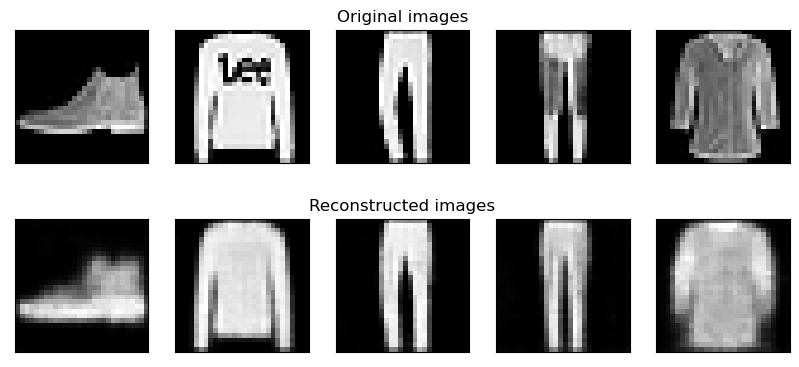

	 partial train loss (single batch): 6723.453125
	 partial train loss (single batch): 6593.285156
	 partial train loss (single batch): 6787.994629
	 partial train loss (single batch): 7012.715332
	 partial train loss (single batch): 6407.249512
	 partial train loss (single batch): 6540.898438
	 partial train loss (single batch): 6960.525879
	 partial train loss (single batch): 6543.688477
	 partial train loss (single batch): 6456.729980
	 partial train loss (single batch): 6361.228027
	 partial train loss (single batch): 6531.089844
	 partial train loss (single batch): 6714.197266
	 partial train loss (single batch): 6713.846680
	 partial train loss (single batch): 6543.045898
	 partial train loss (single batch): 6762.740234
	 partial train loss (single batch): 6530.319824
	 partial train loss (single batch): 6889.067871
	 partial train loss (single batch): 6707.994141
	 partial train loss (single batch): 6352.182617
	 partial train loss (single batch): 6596.792969
	 partial train loss

	 partial train loss (single batch): 6610.330078
	 partial train loss (single batch): 6399.544922
	 partial train loss (single batch): 6561.208984
	 partial train loss (single batch): 6565.907715
	 partial train loss (single batch): 6630.415527
	 partial train loss (single batch): 6601.578125
	 partial train loss (single batch): 6664.406738
	 partial train loss (single batch): 6560.120117
	 partial train loss (single batch): 6569.014160
	 partial train loss (single batch): 6514.965820
	 partial train loss (single batch): 6776.512695
	 partial train loss (single batch): 6343.539062
	 partial train loss (single batch): 6576.134766
	 partial train loss (single batch): 6462.983398
	 partial train loss (single batch): 6410.004883
	 partial train loss (single batch): 6560.329102
	 partial train loss (single batch): 6592.939941
	 partial train loss (single batch): 6687.979004
	 partial train loss (single batch): 6446.573730
	 partial train loss (single batch): 3405.820801

 EPOCH 28/50 	 trai

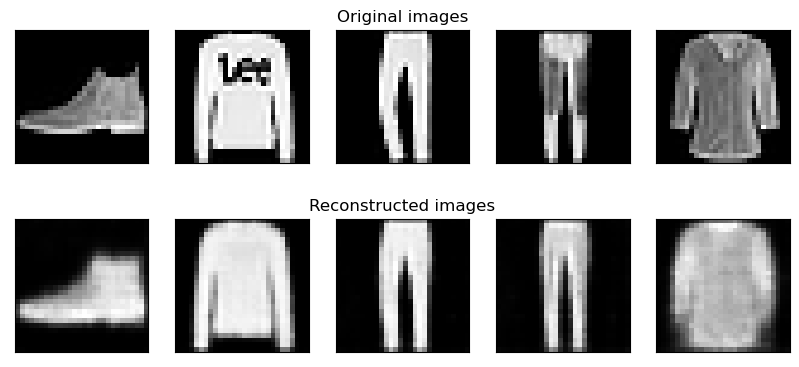

	 partial train loss (single batch): 6788.181641
	 partial train loss (single batch): 6589.087402
	 partial train loss (single batch): 6839.585938
	 partial train loss (single batch): 6997.141602
	 partial train loss (single batch): 6382.099121
	 partial train loss (single batch): 6509.630859
	 partial train loss (single batch): 6945.114746
	 partial train loss (single batch): 6504.603027
	 partial train loss (single batch): 6439.204102
	 partial train loss (single batch): 6340.767578
	 partial train loss (single batch): 6473.156250
	 partial train loss (single batch): 6661.650879
	 partial train loss (single batch): 6623.579102
	 partial train loss (single batch): 6517.029297
	 partial train loss (single batch): 6744.037109
	 partial train loss (single batch): 6514.783691
	 partial train loss (single batch): 6866.407227
	 partial train loss (single batch): 6599.937500
	 partial train loss (single batch): 6408.383789
	 partial train loss (single batch): 6579.203125
	 partial train loss

	 partial train loss (single batch): 6635.293945
	 partial train loss (single batch): 6656.922852
	 partial train loss (single batch): 6745.065918
	 partial train loss (single batch): 6576.452148
	 partial train loss (single batch): 6670.516602
	 partial train loss (single batch): 6494.871094
	 partial train loss (single batch): 6787.748047
	 partial train loss (single batch): 6342.633789
	 partial train loss (single batch): 6590.568359
	 partial train loss (single batch): 6389.007324
	 partial train loss (single batch): 6439.828613
	 partial train loss (single batch): 6597.700684
	 partial train loss (single batch): 6565.752441
	 partial train loss (single batch): 6609.992676
	 partial train loss (single batch): 6405.720215
	 partial train loss (single batch): 3387.604492

 EPOCH 29/50 	 train loss 25.830 	 val loss 25.865


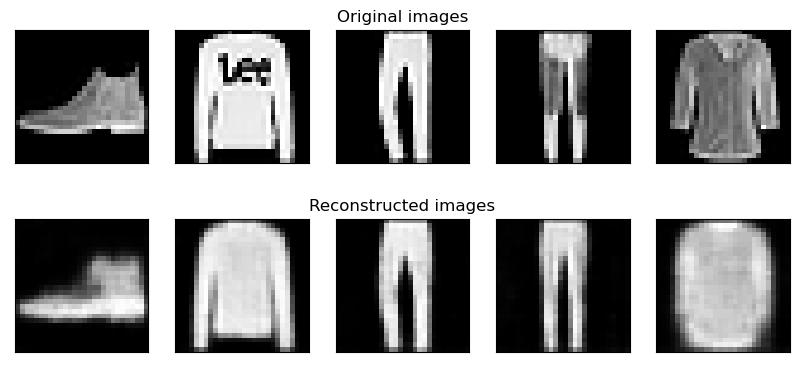

	 partial train loss (single batch): 6713.865723
	 partial train loss (single batch): 6635.959473
	 partial train loss (single batch): 6786.739746
	 partial train loss (single batch): 6941.497070
	 partial train loss (single batch): 6382.333984
	 partial train loss (single batch): 6568.927734
	 partial train loss (single batch): 6921.366699
	 partial train loss (single batch): 6612.398926
	 partial train loss (single batch): 6504.395996
	 partial train loss (single batch): 6395.775879
	 partial train loss (single batch): 6550.821289
	 partial train loss (single batch): 6693.011719
	 partial train loss (single batch): 6775.305176
	 partial train loss (single batch): 6564.246582
	 partial train loss (single batch): 6759.341309
	 partial train loss (single batch): 6545.060059
	 partial train loss (single batch): 6899.745117
	 partial train loss (single batch): 6641.732910
	 partial train loss (single batch): 6422.207520
	 partial train loss (single batch): 6653.588379
	 partial train loss

	 partial train loss (single batch): 6629.328125
	 partial train loss (single batch): 6601.874023
	 partial train loss (single batch): 6626.727051
	 partial train loss (single batch): 6541.598633
	 partial train loss (single batch): 6600.813477
	 partial train loss (single batch): 6433.162598
	 partial train loss (single batch): 6719.618164
	 partial train loss (single batch): 6329.873535
	 partial train loss (single batch): 6546.253906
	 partial train loss (single batch): 6385.999512
	 partial train loss (single batch): 6411.889648
	 partial train loss (single batch): 6538.024414
	 partial train loss (single batch): 6526.122070
	 partial train loss (single batch): 6610.820312
	 partial train loss (single batch): 6396.898438
	 partial train loss (single batch): 3359.067627

 EPOCH 30/50 	 train loss 25.785 	 val loss 25.879


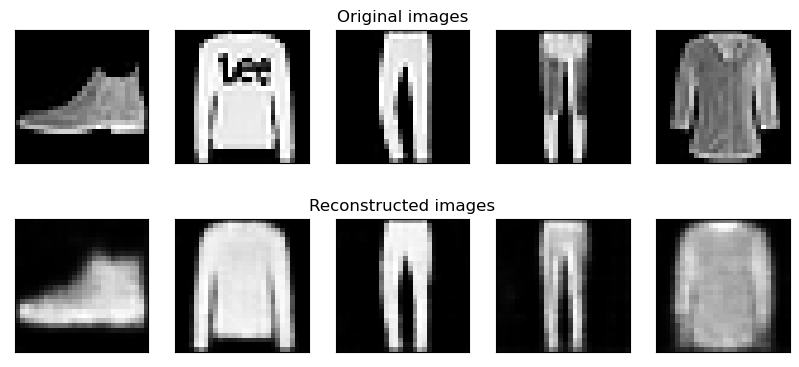

	 partial train loss (single batch): 6719.984863
	 partial train loss (single batch): 6647.679688
	 partial train loss (single batch): 6893.057129
	 partial train loss (single batch): 6978.781250
	 partial train loss (single batch): 6376.493164
	 partial train loss (single batch): 6559.583984
	 partial train loss (single batch): 6927.430664
	 partial train loss (single batch): 6553.439941
	 partial train loss (single batch): 6440.304688
	 partial train loss (single batch): 6398.792480
	 partial train loss (single batch): 6503.481445
	 partial train loss (single batch): 6606.797363
	 partial train loss (single batch): 6675.261719
	 partial train loss (single batch): 6526.186523
	 partial train loss (single batch): 6779.951172
	 partial train loss (single batch): 6534.980469
	 partial train loss (single batch): 6908.877441
	 partial train loss (single batch): 6665.204102
	 partial train loss (single batch): 6370.362793
	 partial train loss (single batch): 6630.815430
	 partial train loss

	 partial train loss (single batch): 6601.006836
	 partial train loss (single batch): 6373.907715
	 partial train loss (single batch): 6601.894531
	 partial train loss (single batch): 6615.375000
	 partial train loss (single batch): 6535.604980
	 partial train loss (single batch): 6634.224609
	 partial train loss (single batch): 6672.018066
	 partial train loss (single batch): 6514.755859
	 partial train loss (single batch): 6661.282227
	 partial train loss (single batch): 6482.839844
	 partial train loss (single batch): 6817.493164
	 partial train loss (single batch): 6307.277344
	 partial train loss (single batch): 6596.434570
	 partial train loss (single batch): 6433.438477
	 partial train loss (single batch): 6456.604492
	 partial train loss (single batch): 6572.559570
	 partial train loss (single batch): 6526.475586
	 partial train loss (single batch): 6600.780762
	 partial train loss (single batch): 6374.377441
	 partial train loss (single batch): 3330.732178

 EPOCH 31/50 	 trai

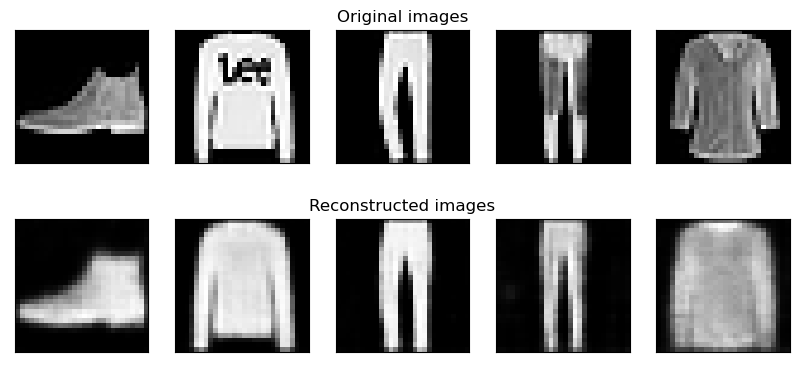

	 partial train loss (single batch): 6688.604004
	 partial train loss (single batch): 6556.302734
	 partial train loss (single batch): 6815.461426
	 partial train loss (single batch): 6960.621094
	 partial train loss (single batch): 6388.117188
	 partial train loss (single batch): 6528.991699
	 partial train loss (single batch): 6878.487305
	 partial train loss (single batch): 6525.840820
	 partial train loss (single batch): 6409.922852
	 partial train loss (single batch): 6361.910156
	 partial train loss (single batch): 6542.229004
	 partial train loss (single batch): 6615.229492
	 partial train loss (single batch): 6669.199219
	 partial train loss (single batch): 6520.526855
	 partial train loss (single batch): 6761.295898
	 partial train loss (single batch): 6565.998047
	 partial train loss (single batch): 6944.650879
	 partial train loss (single batch): 6664.078125
	 partial train loss (single batch): 6436.954102
	 partial train loss (single batch): 6620.391602
	 partial train loss

	 partial train loss (single batch): 6676.260254
	 partial train loss (single batch): 6581.657227
	 partial train loss (single batch): 6602.813477
	 partial train loss (single batch): 6671.103027
	 partial train loss (single batch): 6498.771484
	 partial train loss (single batch): 6594.383301
	 partial train loss (single batch): 6484.908203
	 partial train loss (single batch): 6772.063477
	 partial train loss (single batch): 6348.428711
	 partial train loss (single batch): 6649.756836
	 partial train loss (single batch): 6370.902832
	 partial train loss (single batch): 6448.069336
	 partial train loss (single batch): 6526.956055
	 partial train loss (single batch): 6497.217773
	 partial train loss (single batch): 6611.395996
	 partial train loss (single batch): 6370.619141
	 partial train loss (single batch): 3350.230469

 EPOCH 32/50 	 train loss 25.738 	 val loss 25.809


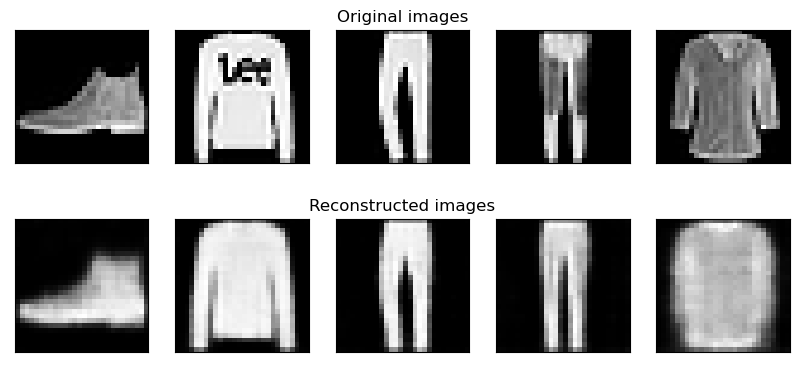

	 partial train loss (single batch): 6710.670410
	 partial train loss (single batch): 6596.178711
	 partial train loss (single batch): 6831.519531
	 partial train loss (single batch): 6977.225586
	 partial train loss (single batch): 6437.143555
	 partial train loss (single batch): 6515.525391
	 partial train loss (single batch): 6918.769043
	 partial train loss (single batch): 6422.577637
	 partial train loss (single batch): 6383.013672
	 partial train loss (single batch): 6411.187500
	 partial train loss (single batch): 6490.437988
	 partial train loss (single batch): 6606.270508
	 partial train loss (single batch): 6628.690918
	 partial train loss (single batch): 6517.205078
	 partial train loss (single batch): 6767.577148
	 partial train loss (single batch): 6465.477539
	 partial train loss (single batch): 6870.713379
	 partial train loss (single batch): 6602.188477
	 partial train loss (single batch): 6343.455078
	 partial train loss (single batch): 6606.271973
	 partial train loss

	 partial train loss (single batch): 6549.027344
	 partial train loss (single batch): 6670.938965
	 partial train loss (single batch): 6557.238281
	 partial train loss (single batch): 6605.041504
	 partial train loss (single batch): 6469.359375
	 partial train loss (single batch): 6826.852539
	 partial train loss (single batch): 6299.129883
	 partial train loss (single batch): 6543.153809
	 partial train loss (single batch): 6432.080566
	 partial train loss (single batch): 6496.775391
	 partial train loss (single batch): 6537.865723
	 partial train loss (single batch): 6482.860840
	 partial train loss (single batch): 6608.041992
	 partial train loss (single batch): 6361.639160
	 partial train loss (single batch): 3362.382812

 EPOCH 33/50 	 train loss 25.735 	 val loss 25.635


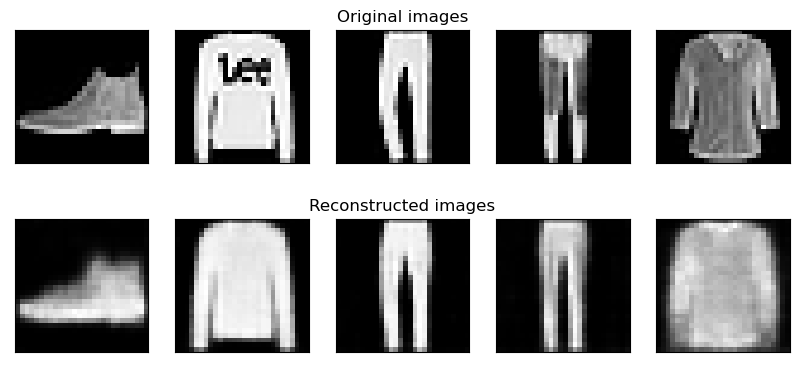

	 partial train loss (single batch): 6677.928711
	 partial train loss (single batch): 6520.245117
	 partial train loss (single batch): 6776.957520
	 partial train loss (single batch): 6934.596191
	 partial train loss (single batch): 6366.593262
	 partial train loss (single batch): 6497.196289
	 partial train loss (single batch): 6883.204102
	 partial train loss (single batch): 6507.896484
	 partial train loss (single batch): 6407.696777
	 partial train loss (single batch): 6343.738281
	 partial train loss (single batch): 6490.897461
	 partial train loss (single batch): 6592.556641
	 partial train loss (single batch): 6621.943359
	 partial train loss (single batch): 6475.147461
	 partial train loss (single batch): 6774.151367
	 partial train loss (single batch): 6469.562988
	 partial train loss (single batch): 6842.398438
	 partial train loss (single batch): 6602.039062
	 partial train loss (single batch): 6386.596680
	 partial train loss (single batch): 6579.954102
	 partial train loss

	 partial train loss (single batch): 6571.569336
	 partial train loss (single batch): 6583.783691
	 partial train loss (single batch): 6571.121582
	 partial train loss (single batch): 6683.579102
	 partial train loss (single batch): 6517.896484
	 partial train loss (single batch): 6609.373047
	 partial train loss (single batch): 6488.092285
	 partial train loss (single batch): 6781.097656
	 partial train loss (single batch): 6298.998535
	 partial train loss (single batch): 6524.050781
	 partial train loss (single batch): 6346.006836
	 partial train loss (single batch): 6510.425293
	 partial train loss (single batch): 6559.395508
	 partial train loss (single batch): 6445.458984
	 partial train loss (single batch): 6598.176758
	 partial train loss (single batch): 6344.688477
	 partial train loss (single batch): 3378.727295

 EPOCH 34/50 	 train loss 25.702 	 val loss 25.854


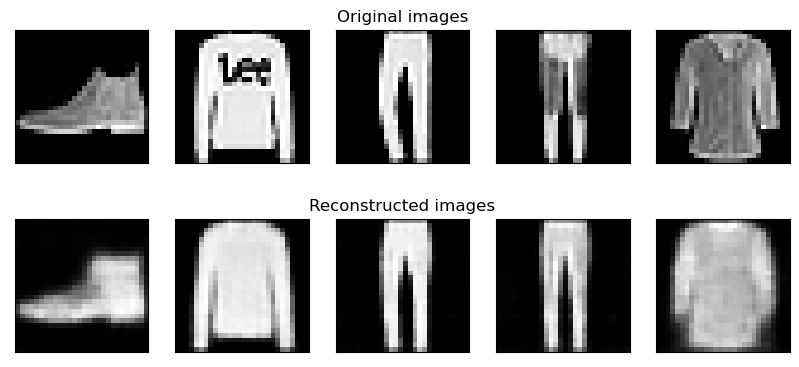

	 partial train loss (single batch): 6644.881836
	 partial train loss (single batch): 6634.075684
	 partial train loss (single batch): 6756.291016
	 partial train loss (single batch): 6963.383789
	 partial train loss (single batch): 6369.260254
	 partial train loss (single batch): 6509.713379
	 partial train loss (single batch): 6924.916016
	 partial train loss (single batch): 6466.965820
	 partial train loss (single batch): 6362.038086
	 partial train loss (single batch): 6345.294922
	 partial train loss (single batch): 6497.535156
	 partial train loss (single batch): 6603.116699
	 partial train loss (single batch): 6696.921875
	 partial train loss (single batch): 6539.894531
	 partial train loss (single batch): 6699.134766
	 partial train loss (single batch): 6496.888672
	 partial train loss (single batch): 6841.240723
	 partial train loss (single batch): 6587.357422
	 partial train loss (single batch): 6409.890625
	 partial train loss (single batch): 6648.980469
	 partial train loss

	 partial train loss (single batch): 6607.014160
	 partial train loss (single batch): 6565.351562
	 partial train loss (single batch): 6598.760742
	 partial train loss (single batch): 6634.433594
	 partial train loss (single batch): 6538.994141
	 partial train loss (single batch): 6586.956055
	 partial train loss (single batch): 6495.497070
	 partial train loss (single batch): 6777.261230
	 partial train loss (single batch): 6362.526367
	 partial train loss (single batch): 6580.679199
	 partial train loss (single batch): 6448.524414
	 partial train loss (single batch): 6390.725586
	 partial train loss (single batch): 6559.791504
	 partial train loss (single batch): 6467.985352
	 partial train loss (single batch): 6572.320312
	 partial train loss (single batch): 6434.933105
	 partial train loss (single batch): 3368.400879

 EPOCH 35/50 	 train loss 25.693 	 val loss 25.758


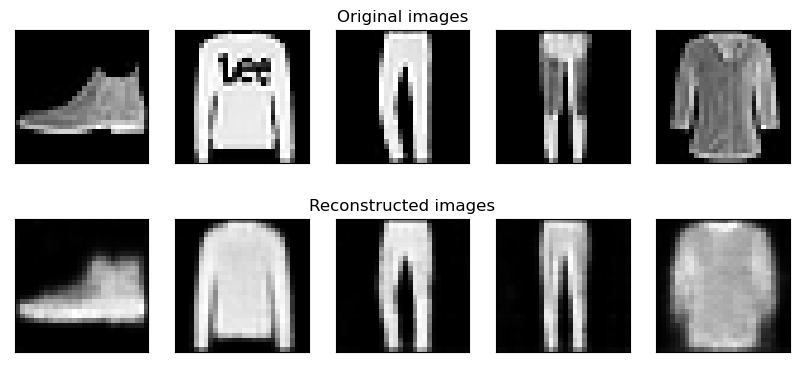

	 partial train loss (single batch): 6649.796875
	 partial train loss (single batch): 6560.827148
	 partial train loss (single batch): 6752.939941
	 partial train loss (single batch): 7024.928711
	 partial train loss (single batch): 6335.323242
	 partial train loss (single batch): 6417.167480
	 partial train loss (single batch): 6891.001465
	 partial train loss (single batch): 6453.714844
	 partial train loss (single batch): 6378.661133
	 partial train loss (single batch): 6329.203125
	 partial train loss (single batch): 6459.203125
	 partial train loss (single batch): 6661.132812
	 partial train loss (single batch): 6663.784668
	 partial train loss (single batch): 6583.623535
	 partial train loss (single batch): 6703.782715
	 partial train loss (single batch): 6498.522461
	 partial train loss (single batch): 6856.737305
	 partial train loss (single batch): 6656.594238
	 partial train loss (single batch): 6383.029297
	 partial train loss (single batch): 6589.002441
	 partial train loss

	 partial train loss (single batch): 6586.026855
	 partial train loss (single batch): 6539.546387
	 partial train loss (single batch): 6515.899414
	 partial train loss (single batch): 6644.844727
	 partial train loss (single batch): 6531.378418
	 partial train loss (single batch): 6561.079590
	 partial train loss (single batch): 6491.508789
	 partial train loss (single batch): 6692.447266
	 partial train loss (single batch): 6331.459473
	 partial train loss (single batch): 6509.704102
	 partial train loss (single batch): 6415.121094
	 partial train loss (single batch): 6410.533691
	 partial train loss (single batch): 6549.014648
	 partial train loss (single batch): 6462.938477
	 partial train loss (single batch): 6611.848633
	 partial train loss (single batch): 6409.899902
	 partial train loss (single batch): 3378.037598

 EPOCH 36/50 	 train loss 25.663 	 val loss 25.682


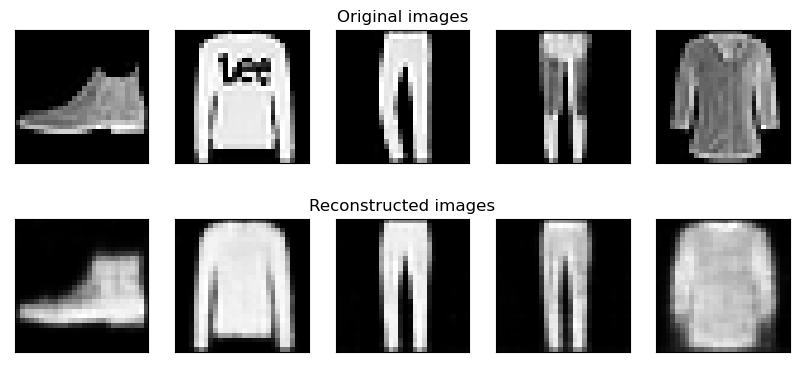

	 partial train loss (single batch): 6688.846680
	 partial train loss (single batch): 6612.968750
	 partial train loss (single batch): 6750.626953
	 partial train loss (single batch): 6947.165039
	 partial train loss (single batch): 6285.827148
	 partial train loss (single batch): 6541.375488
	 partial train loss (single batch): 6902.193359
	 partial train loss (single batch): 6530.925781
	 partial train loss (single batch): 6436.884277
	 partial train loss (single batch): 6344.578613
	 partial train loss (single batch): 6462.913574
	 partial train loss (single batch): 6567.627930
	 partial train loss (single batch): 6619.107422
	 partial train loss (single batch): 6486.778320
	 partial train loss (single batch): 6781.101562
	 partial train loss (single batch): 6496.320801
	 partial train loss (single batch): 6836.673340
	 partial train loss (single batch): 6607.235840
	 partial train loss (single batch): 6457.377441
	 partial train loss (single batch): 6587.506836
	 partial train loss

	 partial train loss (single batch): 6530.598633
	 partial train loss (single batch): 6595.233887
	 partial train loss (single batch): 6599.271484
	 partial train loss (single batch): 6575.375000
	 partial train loss (single batch): 6661.244629
	 partial train loss (single batch): 6495.891113
	 partial train loss (single batch): 6638.647461
	 partial train loss (single batch): 6511.227539
	 partial train loss (single batch): 6716.542969
	 partial train loss (single batch): 6329.053223
	 partial train loss (single batch): 6523.893066
	 partial train loss (single batch): 6377.106934
	 partial train loss (single batch): 6451.565918
	 partial train loss (single batch): 6582.132812
	 partial train loss (single batch): 6485.455078
	 partial train loss (single batch): 6563.981445
	 partial train loss (single batch): 6319.493164
	 partial train loss (single batch): 3326.347412

 EPOCH 37/50 	 train loss 25.638 	 val loss 25.603


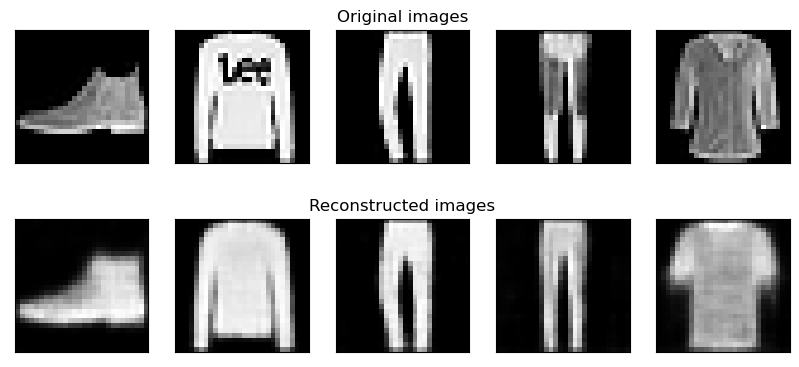

	 partial train loss (single batch): 6633.298340
	 partial train loss (single batch): 6513.557617
	 partial train loss (single batch): 6727.353516
	 partial train loss (single batch): 6864.008789
	 partial train loss (single batch): 6344.241211
	 partial train loss (single batch): 6478.626953
	 partial train loss (single batch): 6880.998047
	 partial train loss (single batch): 6419.274414
	 partial train loss (single batch): 6385.473145
	 partial train loss (single batch): 6307.563965
	 partial train loss (single batch): 6483.134766
	 partial train loss (single batch): 6627.195312
	 partial train loss (single batch): 6575.160156
	 partial train loss (single batch): 6524.874023
	 partial train loss (single batch): 6721.389160
	 partial train loss (single batch): 6462.486816
	 partial train loss (single batch): 6806.571777
	 partial train loss (single batch): 6578.788574
	 partial train loss (single batch): 6349.465820
	 partial train loss (single batch): 6586.825684
	 partial train loss

	 partial train loss (single batch): 6591.935547
	 partial train loss (single batch): 6598.244629
	 partial train loss (single batch): 6601.387695
	 partial train loss (single batch): 6693.135742
	 partial train loss (single batch): 6531.234863
	 partial train loss (single batch): 6553.962402
	 partial train loss (single batch): 6489.580566
	 partial train loss (single batch): 6751.214844
	 partial train loss (single batch): 6342.150391
	 partial train loss (single batch): 6572.116211
	 partial train loss (single batch): 6352.228516
	 partial train loss (single batch): 6450.841797
	 partial train loss (single batch): 6583.237305
	 partial train loss (single batch): 6531.532715
	 partial train loss (single batch): 6560.700195
	 partial train loss (single batch): 6363.803711
	 partial train loss (single batch): 3377.337891

 EPOCH 38/50 	 train loss 25.621 	 val loss 25.766


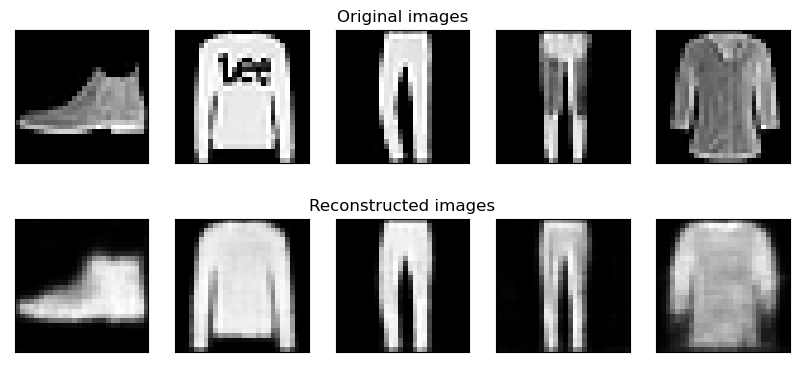

	 partial train loss (single batch): 6676.023438
	 partial train loss (single batch): 6547.082031
	 partial train loss (single batch): 6753.665039
	 partial train loss (single batch): 6986.295410
	 partial train loss (single batch): 6346.872559
	 partial train loss (single batch): 6512.653320
	 partial train loss (single batch): 6899.304688
	 partial train loss (single batch): 6521.882812
	 partial train loss (single batch): 6423.546875
	 partial train loss (single batch): 6381.915527
	 partial train loss (single batch): 6453.850586
	 partial train loss (single batch): 6553.092285
	 partial train loss (single batch): 6612.136719
	 partial train loss (single batch): 6507.593750
	 partial train loss (single batch): 6756.377930
	 partial train loss (single batch): 6422.158203
	 partial train loss (single batch): 6856.092773
	 partial train loss (single batch): 6566.297363
	 partial train loss (single batch): 6418.184570
	 partial train loss (single batch): 6541.858887
	 partial train loss

	 partial train loss (single batch): 6526.437012
	 partial train loss (single batch): 6559.233398
	 partial train loss (single batch): 6660.870605
	 partial train loss (single batch): 6485.604492
	 partial train loss (single batch): 6547.194824
	 partial train loss (single batch): 6484.981445
	 partial train loss (single batch): 6778.674316
	 partial train loss (single batch): 6333.067383
	 partial train loss (single batch): 6533.074707
	 partial train loss (single batch): 6305.806152
	 partial train loss (single batch): 6379.952148
	 partial train loss (single batch): 6511.447266
	 partial train loss (single batch): 6486.823730
	 partial train loss (single batch): 6482.513672
	 partial train loss (single batch): 6255.644043
	 partial train loss (single batch): 3324.161865

 EPOCH 39/50 	 train loss 25.631 	 val loss 25.552


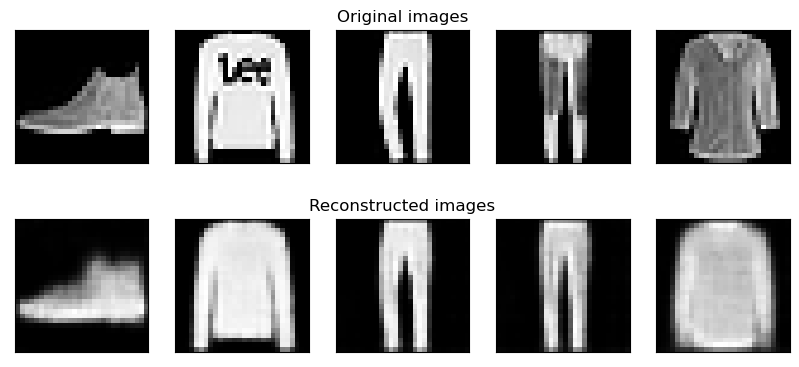

	 partial train loss (single batch): 6716.996582
	 partial train loss (single batch): 6560.879883
	 partial train loss (single batch): 6791.158691
	 partial train loss (single batch): 6907.679688
	 partial train loss (single batch): 6329.797852
	 partial train loss (single batch): 6483.164551
	 partial train loss (single batch): 6839.324219
	 partial train loss (single batch): 6433.385254
	 partial train loss (single batch): 6358.995117
	 partial train loss (single batch): 6325.523438
	 partial train loss (single batch): 6453.013672
	 partial train loss (single batch): 6587.110352
	 partial train loss (single batch): 6610.516602
	 partial train loss (single batch): 6471.858398
	 partial train loss (single batch): 6675.942383
	 partial train loss (single batch): 6488.352539
	 partial train loss (single batch): 6846.623535
	 partial train loss (single batch): 6562.860352
	 partial train loss (single batch): 6403.434570
	 partial train loss (single batch): 6574.635254
	 partial train loss

	 partial train loss (single batch): 6549.549316
	 partial train loss (single batch): 6523.554688
	 partial train loss (single batch): 6536.627930
	 partial train loss (single batch): 6580.947266
	 partial train loss (single batch): 6657.147949
	 partial train loss (single batch): 6517.310547
	 partial train loss (single batch): 6532.270020
	 partial train loss (single batch): 6453.380859
	 partial train loss (single batch): 6719.274414
	 partial train loss (single batch): 6346.588379
	 partial train loss (single batch): 6524.425781
	 partial train loss (single batch): 6423.920898
	 partial train loss (single batch): 6361.225586
	 partial train loss (single batch): 6508.981445
	 partial train loss (single batch): 6432.568359
	 partial train loss (single batch): 6531.711914
	 partial train loss (single batch): 6316.346191
	 partial train loss (single batch): 3348.750488

 EPOCH 40/50 	 train loss 25.582 	 val loss 25.677


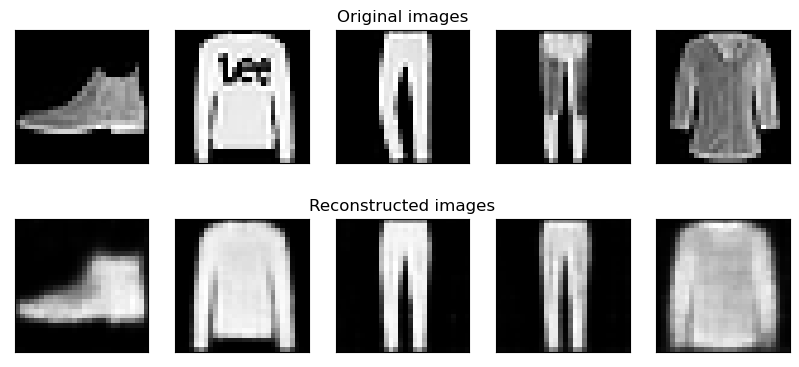

	 partial train loss (single batch): 6715.752441
	 partial train loss (single batch): 6562.764648
	 partial train loss (single batch): 6774.272461
	 partial train loss (single batch): 6891.360840
	 partial train loss (single batch): 6324.231934
	 partial train loss (single batch): 6491.059570
	 partial train loss (single batch): 6911.865723
	 partial train loss (single batch): 6435.250977
	 partial train loss (single batch): 6333.250977
	 partial train loss (single batch): 6288.755371
	 partial train loss (single batch): 6429.114746
	 partial train loss (single batch): 6579.619141
	 partial train loss (single batch): 6550.068848
	 partial train loss (single batch): 6476.977539
	 partial train loss (single batch): 6744.668945
	 partial train loss (single batch): 6459.470215
	 partial train loss (single batch): 6835.557617
	 partial train loss (single batch): 6549.395996
	 partial train loss (single batch): 6394.562500
	 partial train loss (single batch): 6591.326172
	 partial train loss

	 partial train loss (single batch): 6564.137695
	 partial train loss (single batch): 6526.733398
	 partial train loss (single batch): 6572.733887
	 partial train loss (single batch): 6657.457031
	 partial train loss (single batch): 6485.239258
	 partial train loss (single batch): 6582.382812
	 partial train loss (single batch): 6430.109863
	 partial train loss (single batch): 6747.980957
	 partial train loss (single batch): 6331.313965
	 partial train loss (single batch): 6491.469727
	 partial train loss (single batch): 6370.524414
	 partial train loss (single batch): 6399.250000
	 partial train loss (single batch): 6567.125488
	 partial train loss (single batch): 6489.313477
	 partial train loss (single batch): 6532.040039
	 partial train loss (single batch): 6347.981934
	 partial train loss (single batch): 3366.202148

 EPOCH 41/50 	 train loss 25.577 	 val loss 25.845


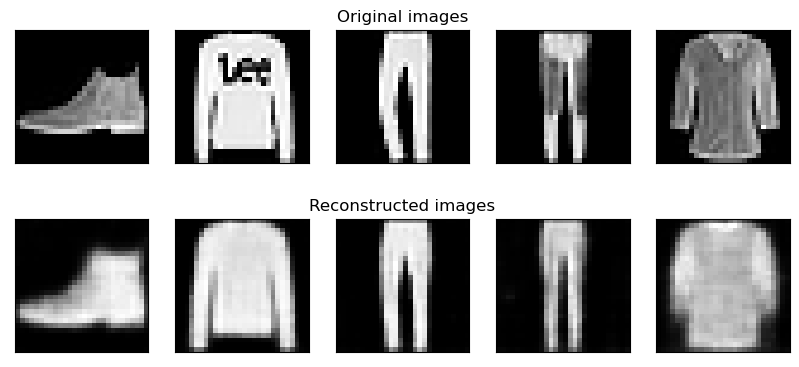

	 partial train loss (single batch): 6688.699707
	 partial train loss (single batch): 6573.260254
	 partial train loss (single batch): 6767.130371
	 partial train loss (single batch): 6930.762695
	 partial train loss (single batch): 6328.314453
	 partial train loss (single batch): 6438.566406
	 partial train loss (single batch): 6944.162109
	 partial train loss (single batch): 6419.920898
	 partial train loss (single batch): 6371.110840
	 partial train loss (single batch): 6336.537598
	 partial train loss (single batch): 6496.158691
	 partial train loss (single batch): 6623.454102
	 partial train loss (single batch): 6704.105957
	 partial train loss (single batch): 6519.137207
	 partial train loss (single batch): 6674.185059
	 partial train loss (single batch): 6489.861328
	 partial train loss (single batch): 6862.302246
	 partial train loss (single batch): 6630.426758
	 partial train loss (single batch): 6308.558594
	 partial train loss (single batch): 6570.653320
	 partial train loss

	 partial train loss (single batch): 6634.850098
	 partial train loss (single batch): 6605.739258
	 partial train loss (single batch): 6522.128906
	 partial train loss (single batch): 6552.272461
	 partial train loss (single batch): 6630.023438
	 partial train loss (single batch): 6502.126953
	 partial train loss (single batch): 6590.639648
	 partial train loss (single batch): 6525.775391
	 partial train loss (single batch): 6691.794434
	 partial train loss (single batch): 6304.128906
	 partial train loss (single batch): 6513.292969
	 partial train loss (single batch): 6350.483398
	 partial train loss (single batch): 6433.698730
	 partial train loss (single batch): 6527.224121
	 partial train loss (single batch): 6490.666016
	 partial train loss (single batch): 6551.550781
	 partial train loss (single batch): 6313.661133
	 partial train loss (single batch): 3301.759766

 EPOCH 42/50 	 train loss 25.573 	 val loss 25.677


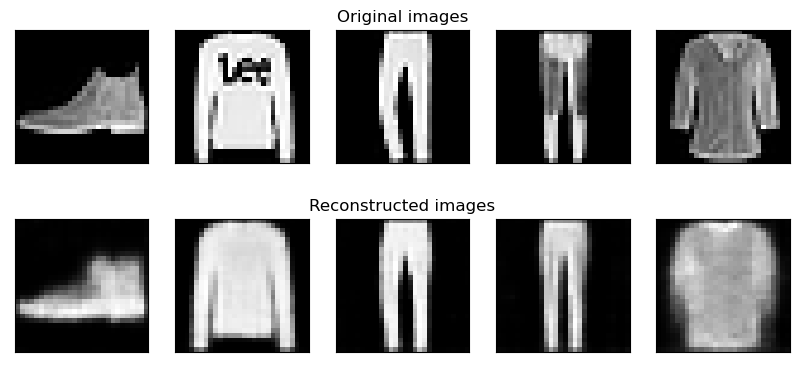

	 partial train loss (single batch): 6618.711914
	 partial train loss (single batch): 6569.444336
	 partial train loss (single batch): 6699.141113
	 partial train loss (single batch): 6941.819336
	 partial train loss (single batch): 6286.854004
	 partial train loss (single batch): 6456.462402
	 partial train loss (single batch): 6809.076172
	 partial train loss (single batch): 6424.439453
	 partial train loss (single batch): 6379.547852
	 partial train loss (single batch): 6299.576172
	 partial train loss (single batch): 6442.022461
	 partial train loss (single batch): 6593.857422
	 partial train loss (single batch): 6571.635742
	 partial train loss (single batch): 6456.338867
	 partial train loss (single batch): 6646.579102
	 partial train loss (single batch): 6483.516113
	 partial train loss (single batch): 6845.934570
	 partial train loss (single batch): 6576.664062
	 partial train loss (single batch): 6350.410645
	 partial train loss (single batch): 6586.280273
	 partial train loss

	 partial train loss (single batch): 6589.108398
	 partial train loss (single batch): 6603.380371
	 partial train loss (single batch): 6556.632812
	 partial train loss (single batch): 6634.692383
	 partial train loss (single batch): 6498.000000
	 partial train loss (single batch): 6522.073242
	 partial train loss (single batch): 6517.793945
	 partial train loss (single batch): 6716.879883
	 partial train loss (single batch): 6295.843750
	 partial train loss (single batch): 6484.216797
	 partial train loss (single batch): 6359.192871
	 partial train loss (single batch): 6409.488281
	 partial train loss (single batch): 6518.382324
	 partial train loss (single batch): 6497.396973
	 partial train loss (single batch): 6532.235352
	 partial train loss (single batch): 6318.183594
	 partial train loss (single batch): 3334.935547

 EPOCH 43/50 	 train loss 25.559 	 val loss 25.677


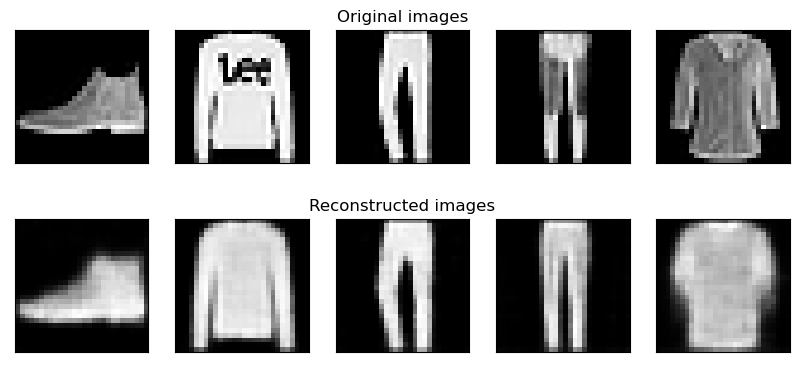

	 partial train loss (single batch): 6673.751953
	 partial train loss (single batch): 6549.699707
	 partial train loss (single batch): 6752.790039
	 partial train loss (single batch): 6876.898438
	 partial train loss (single batch): 6283.444336
	 partial train loss (single batch): 6437.428711
	 partial train loss (single batch): 6896.598145
	 partial train loss (single batch): 6454.299316
	 partial train loss (single batch): 6369.631836
	 partial train loss (single batch): 6301.360840
	 partial train loss (single batch): 6431.830566
	 partial train loss (single batch): 6566.553711
	 partial train loss (single batch): 6615.000000
	 partial train loss (single batch): 6417.617188
	 partial train loss (single batch): 6709.182617
	 partial train loss (single batch): 6460.711914
	 partial train loss (single batch): 6918.666016
	 partial train loss (single batch): 6584.926758
	 partial train loss (single batch): 6327.316406
	 partial train loss (single batch): 6558.823730
	 partial train loss

	 partial train loss (single batch): 6547.730957
	 partial train loss (single batch): 6590.121582
	 partial train loss (single batch): 6625.660156
	 partial train loss (single batch): 6455.448242
	 partial train loss (single batch): 6566.007812
	 partial train loss (single batch): 6461.782715
	 partial train loss (single batch): 6778.665039
	 partial train loss (single batch): 6292.187988
	 partial train loss (single batch): 6482.418945
	 partial train loss (single batch): 6384.288574
	 partial train loss (single batch): 6349.312988
	 partial train loss (single batch): 6557.644043
	 partial train loss (single batch): 6485.497559
	 partial train loss (single batch): 6596.539551
	 partial train loss (single batch): 6389.285156
	 partial train loss (single batch): 3368.081543

 EPOCH 44/50 	 train loss 25.552 	 val loss 25.607


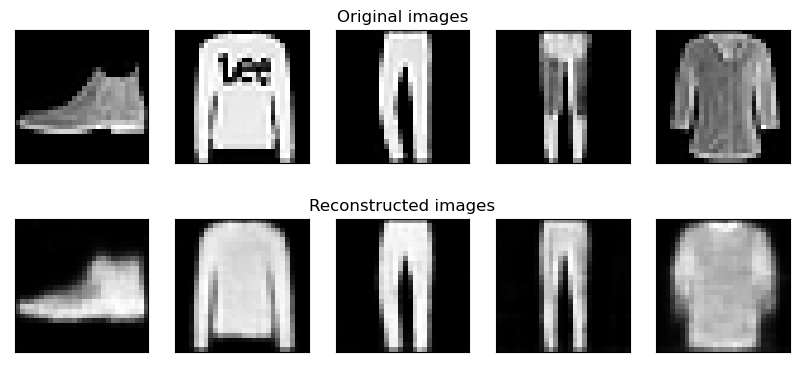

	 partial train loss (single batch): 6683.570312
	 partial train loss (single batch): 6575.219727
	 partial train loss (single batch): 6753.599609
	 partial train loss (single batch): 6965.064453
	 partial train loss (single batch): 6314.526855
	 partial train loss (single batch): 6446.893066
	 partial train loss (single batch): 6824.380371
	 partial train loss (single batch): 6439.858398
	 partial train loss (single batch): 6319.039551
	 partial train loss (single batch): 6304.746582
	 partial train loss (single batch): 6488.214355
	 partial train loss (single batch): 6509.841797
	 partial train loss (single batch): 6576.913086
	 partial train loss (single batch): 6499.697266
	 partial train loss (single batch): 6714.343750
	 partial train loss (single batch): 6432.673828
	 partial train loss (single batch): 6836.516602
	 partial train loss (single batch): 6566.525391
	 partial train loss (single batch): 6347.279297
	 partial train loss (single batch): 6537.722656
	 partial train loss

	 partial train loss (single batch): 6414.205566
	 partial train loss (single batch): 6549.379883
	 partial train loss (single batch): 6553.244141
	 partial train loss (single batch): 6551.810547
	 partial train loss (single batch): 6550.844727
	 partial train loss (single batch): 6595.113770
	 partial train loss (single batch): 6432.583496
	 partial train loss (single batch): 6568.494141
	 partial train loss (single batch): 6462.587402
	 partial train loss (single batch): 6700.631836
	 partial train loss (single batch): 6268.929199
	 partial train loss (single batch): 6529.844727
	 partial train loss (single batch): 6332.938965
	 partial train loss (single batch): 6363.298828
	 partial train loss (single batch): 6529.088867
	 partial train loss (single batch): 6446.031738
	 partial train loss (single batch): 6550.102539
	 partial train loss (single batch): 6277.975586
	 partial train loss (single batch): 3287.014160

 EPOCH 45/50 	 train loss 25.530 	 val loss 25.632


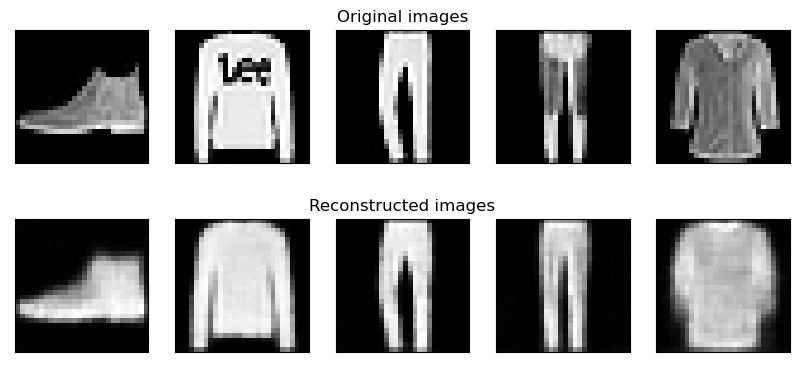

	 partial train loss (single batch): 6709.497070
	 partial train loss (single batch): 6526.062012
	 partial train loss (single batch): 6767.350586
	 partial train loss (single batch): 6882.391113
	 partial train loss (single batch): 6360.624023
	 partial train loss (single batch): 6481.844238
	 partial train loss (single batch): 6882.744629
	 partial train loss (single batch): 6412.080078
	 partial train loss (single batch): 6336.188477
	 partial train loss (single batch): 6278.784180
	 partial train loss (single batch): 6431.050781
	 partial train loss (single batch): 6527.365234
	 partial train loss (single batch): 6694.902832
	 partial train loss (single batch): 6470.880371
	 partial train loss (single batch): 6644.365234
	 partial train loss (single batch): 6431.677734
	 partial train loss (single batch): 6819.277832
	 partial train loss (single batch): 6593.573242
	 partial train loss (single batch): 6306.054199
	 partial train loss (single batch): 6518.445312
	 partial train loss

	 partial train loss (single batch): 6514.252930
	 partial train loss (single batch): 6568.397949
	 partial train loss (single batch): 6610.208008
	 partial train loss (single batch): 6467.648926
	 partial train loss (single batch): 6580.415039
	 partial train loss (single batch): 6448.019531
	 partial train loss (single batch): 6704.760254
	 partial train loss (single batch): 6295.199219
	 partial train loss (single batch): 6497.395996
	 partial train loss (single batch): 6318.622070
	 partial train loss (single batch): 6407.257812
	 partial train loss (single batch): 6529.815430
	 partial train loss (single batch): 6493.148926
	 partial train loss (single batch): 6532.927734
	 partial train loss (single batch): 6358.276367
	 partial train loss (single batch): 3340.134766

 EPOCH 46/50 	 train loss 25.512 	 val loss 25.599


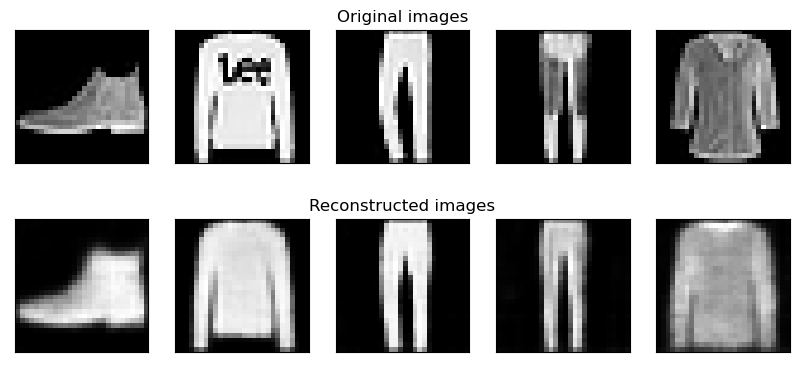

	 partial train loss (single batch): 6613.541992
	 partial train loss (single batch): 6494.914551
	 partial train loss (single batch): 6745.960938
	 partial train loss (single batch): 6896.791504
	 partial train loss (single batch): 6289.494141
	 partial train loss (single batch): 6436.946289
	 partial train loss (single batch): 6832.248047
	 partial train loss (single batch): 6408.340820
	 partial train loss (single batch): 6350.397949
	 partial train loss (single batch): 6320.030273
	 partial train loss (single batch): 6470.300781
	 partial train loss (single batch): 6516.313477
	 partial train loss (single batch): 6549.803711
	 partial train loss (single batch): 6429.094238
	 partial train loss (single batch): 6655.137695
	 partial train loss (single batch): 6408.506836
	 partial train loss (single batch): 6801.809082
	 partial train loss (single batch): 6592.097656
	 partial train loss (single batch): 6334.521973
	 partial train loss (single batch): 6577.501953
	 partial train loss

	 partial train loss (single batch): 6571.068359
	 partial train loss (single batch): 6555.345215
	 partial train loss (single batch): 6575.250488
	 partial train loss (single batch): 6625.962891
	 partial train loss (single batch): 6475.200684
	 partial train loss (single batch): 6612.983398
	 partial train loss (single batch): 6416.295898
	 partial train loss (single batch): 6721.480957
	 partial train loss (single batch): 6325.179688
	 partial train loss (single batch): 6476.819336
	 partial train loss (single batch): 6326.287109
	 partial train loss (single batch): 6366.740723
	 partial train loss (single batch): 6539.138672
	 partial train loss (single batch): 6497.202148
	 partial train loss (single batch): 6492.527832
	 partial train loss (single batch): 6248.863281
	 partial train loss (single batch): 3329.287109

 EPOCH 47/50 	 train loss 25.509 	 val loss 25.535


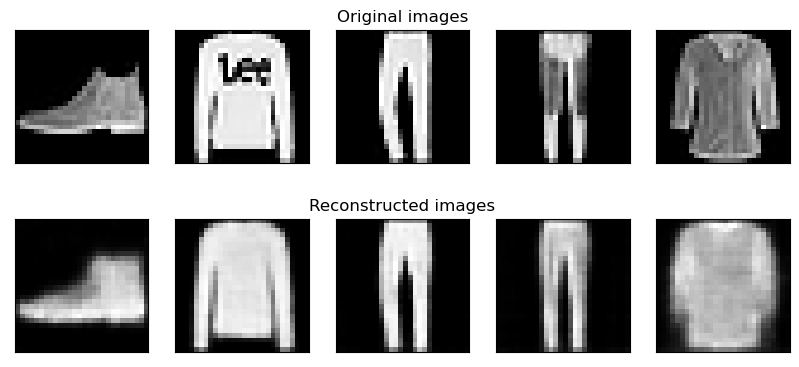

	 partial train loss (single batch): 6657.460938
	 partial train loss (single batch): 6585.122070
	 partial train loss (single batch): 6730.217285
	 partial train loss (single batch): 6869.510742
	 partial train loss (single batch): 6227.116211
	 partial train loss (single batch): 6455.145508
	 partial train loss (single batch): 6838.719727
	 partial train loss (single batch): 6436.796875
	 partial train loss (single batch): 6335.712891
	 partial train loss (single batch): 6363.398926
	 partial train loss (single batch): 6448.409180
	 partial train loss (single batch): 6519.886230
	 partial train loss (single batch): 6557.170898
	 partial train loss (single batch): 6443.324219
	 partial train loss (single batch): 6611.322754
	 partial train loss (single batch): 6422.076172
	 partial train loss (single batch): 6931.500000
	 partial train loss (single batch): 6543.659668
	 partial train loss (single batch): 6350.180664
	 partial train loss (single batch): 6479.931641
	 partial train loss

	 partial train loss (single batch): 6512.643066
	 partial train loss (single batch): 6581.001465
	 partial train loss (single batch): 6621.343750
	 partial train loss (single batch): 6499.952637
	 partial train loss (single batch): 6481.591797
	 partial train loss (single batch): 6418.604980
	 partial train loss (single batch): 6732.480957
	 partial train loss (single batch): 6284.488770
	 partial train loss (single batch): 6479.850098
	 partial train loss (single batch): 6334.186035
	 partial train loss (single batch): 6331.263184
	 partial train loss (single batch): 6547.383789
	 partial train loss (single batch): 6393.354492
	 partial train loss (single batch): 6554.688477
	 partial train loss (single batch): 6235.627930
	 partial train loss (single batch): 3345.061035

 EPOCH 48/50 	 train loss 25.478 	 val loss 25.604


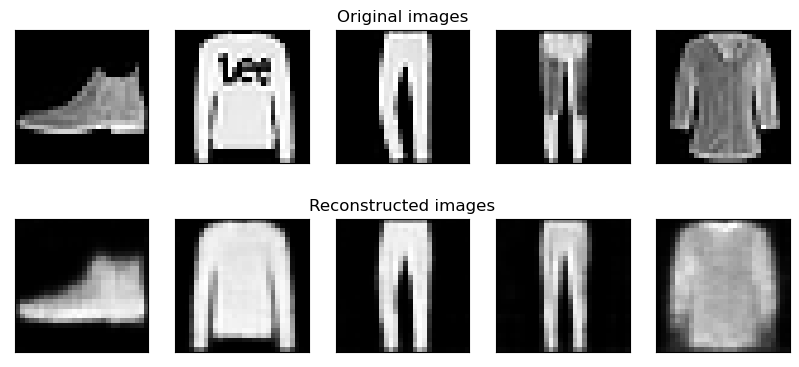

	 partial train loss (single batch): 6590.214844
	 partial train loss (single batch): 6541.305664
	 partial train loss (single batch): 6681.324219
	 partial train loss (single batch): 6902.514648
	 partial train loss (single batch): 6276.953125
	 partial train loss (single batch): 6442.904297
	 partial train loss (single batch): 6858.911133
	 partial train loss (single batch): 6421.530762
	 partial train loss (single batch): 6328.303711
	 partial train loss (single batch): 6281.033203
	 partial train loss (single batch): 6422.108887
	 partial train loss (single batch): 6506.160156
	 partial train loss (single batch): 6598.622559
	 partial train loss (single batch): 6435.257324
	 partial train loss (single batch): 6655.873535
	 partial train loss (single batch): 6447.499023
	 partial train loss (single batch): 6774.819336
	 partial train loss (single batch): 6517.853027
	 partial train loss (single batch): 6338.901367
	 partial train loss (single batch): 6597.738770
	 partial train loss

	 partial train loss (single batch): 6541.203125
	 partial train loss (single batch): 6547.497070
	 partial train loss (single batch): 6540.825195
	 partial train loss (single batch): 6532.468262
	 partial train loss (single batch): 6630.476074
	 partial train loss (single batch): 6511.897949
	 partial train loss (single batch): 6569.687500
	 partial train loss (single batch): 6491.772949
	 partial train loss (single batch): 6720.009766
	 partial train loss (single batch): 6274.184570
	 partial train loss (single batch): 6474.111328
	 partial train loss (single batch): 6321.790039
	 partial train loss (single batch): 6404.780762
	 partial train loss (single batch): 6502.836914
	 partial train loss (single batch): 6475.906250
	 partial train loss (single batch): 6541.504395
	 partial train loss (single batch): 6384.512207
	 partial train loss (single batch): 3353.061523

 EPOCH 49/50 	 train loss 25.487 	 val loss 25.666


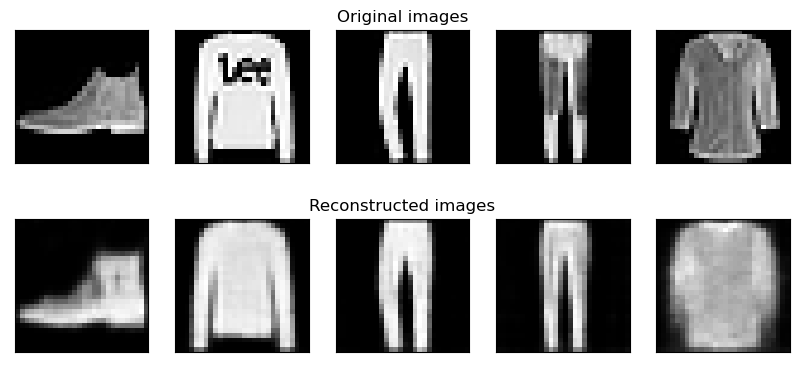

	 partial train loss (single batch): 6657.963867
	 partial train loss (single batch): 6549.631348
	 partial train loss (single batch): 6725.283691
	 partial train loss (single batch): 6919.663086
	 partial train loss (single batch): 6269.803711
	 partial train loss (single batch): 6422.762207
	 partial train loss (single batch): 6810.790039
	 partial train loss (single batch): 6382.600098
	 partial train loss (single batch): 6379.567383
	 partial train loss (single batch): 6284.404785
	 partial train loss (single batch): 6389.411133
	 partial train loss (single batch): 6526.456055
	 partial train loss (single batch): 6628.020508
	 partial train loss (single batch): 6398.814941
	 partial train loss (single batch): 6645.880859
	 partial train loss (single batch): 6457.466309
	 partial train loss (single batch): 6878.474121
	 partial train loss (single batch): 6557.146484
	 partial train loss (single batch): 6326.485352
	 partial train loss (single batch): 6526.458496
	 partial train loss

	 partial train loss (single batch): 6482.126465
	 partial train loss (single batch): 6490.807129
	 partial train loss (single batch): 6498.138672
	 partial train loss (single batch): 6638.203125
	 partial train loss (single batch): 6461.352051
	 partial train loss (single batch): 6564.046387
	 partial train loss (single batch): 6395.490723
	 partial train loss (single batch): 6685.124023
	 partial train loss (single batch): 6272.615234
	 partial train loss (single batch): 6444.504883
	 partial train loss (single batch): 6355.812012
	 partial train loss (single batch): 6339.573242
	 partial train loss (single batch): 6465.299805
	 partial train loss (single batch): 6496.895996
	 partial train loss (single batch): 6501.226074
	 partial train loss (single batch): 6348.863281
	 partial train loss (single batch): 3362.926025

 EPOCH 50/50 	 train loss 25.452 	 val loss 25.700


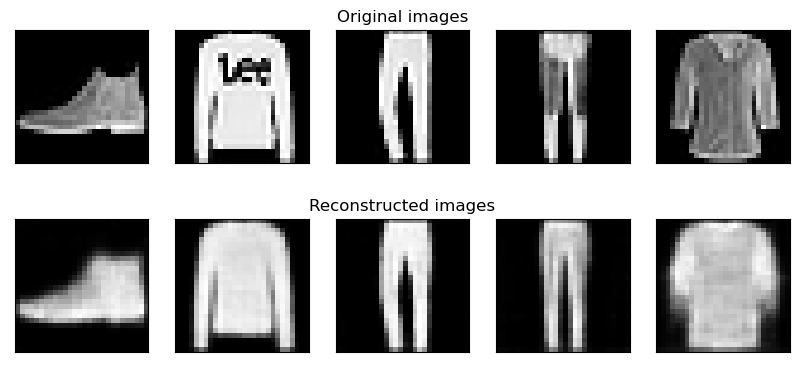

In [16]:
num_epochs = 50
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 生成样本

In [42]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[i,j,x, y]]).to(device)
            
            x_hat = decoder(z)
            #x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            x_hat = x_hat.cpu().squeeze().detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

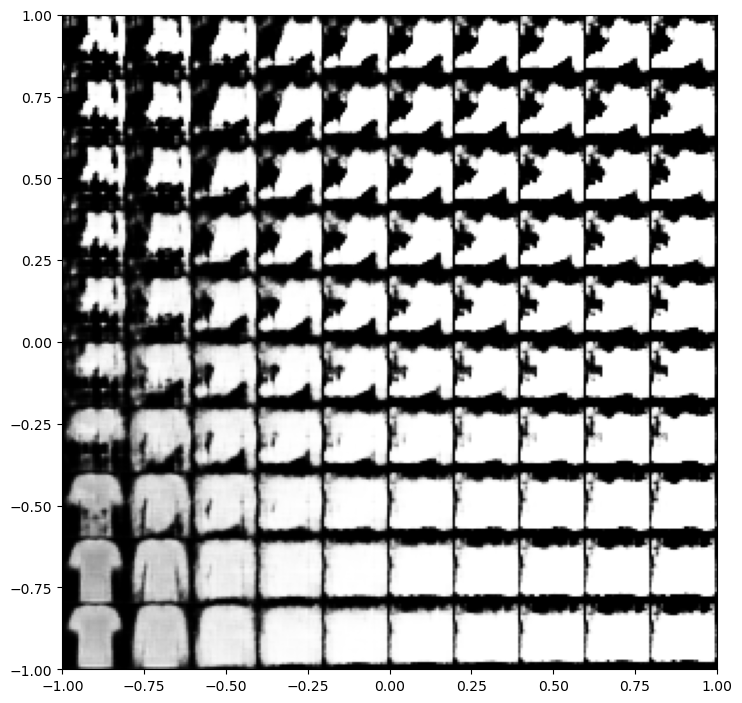

In [43]:
plot_reconstructed(vae.decoder, r0=(-1,1), r1=(-1,1))

## 从隐空间生成新的样本

In [20]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

## 可视化隐空间代码

In [21]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 683.70it/s]


In [22]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-1.075868,0.480466,-0.333105,0.889482,9
1,0.929270,0.842912,0.415643,-0.921094,2
2,1.410330,-1.591020,-0.453439,0.066341,1
3,0.467950,-1.164787,-0.302029,0.345662,1
4,0.475474,0.111756,-0.576840,-0.402049,6
...,...,...,...,...,...
9995,-0.165138,1.021544,-0.554955,0.707546,9
9996,-0.231623,-0.780560,0.402229,0.579843,1
9997,-1.887914,-0.397194,0.057312,0.129467,8
9998,-0.641481,-1.499234,-0.292078,0.576707,1


## 查看统计信息

In [23]:
encoded_samples['Enc. Variable 0'].describe()

count    10000.000000
mean         0.037994
std          0.704563
min         -2.380841
25%         -0.423012
50%          0.068800
75%          0.494330
max          2.663089
Name: Enc. Variable 0, dtype: float64

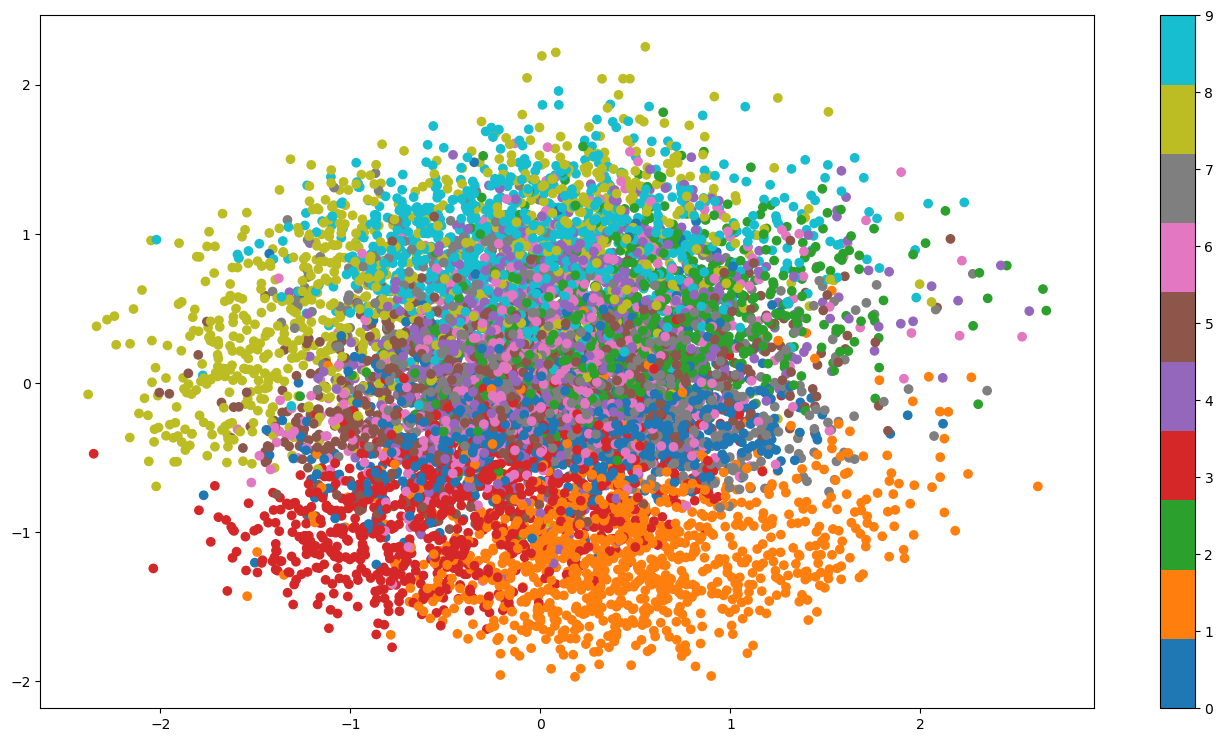

In [24]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

## 从隐空间抽取几个点，生成新图像

In [25]:
def plot_reconstructed_one(decoder, x1,x2,x3,x4,n=1):
    plt.figure(figsize=(3,2))
    w = 28
    img = np.zeros((n*w, n*w))
    #for i, y in enumerate(np.linspace(*r1, n)):
    i=j=0
        #for j, x in enumerate(np.linspace(*r0, n)):
    
    z = torch.Tensor([[x1,x2,x3,x4]]).to(device)
    x_hat = decoder(z)
    x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
    #img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    #plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
    plt.title(str([ x1,x2,x3,x4]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_hat,cmap='gist_gray')

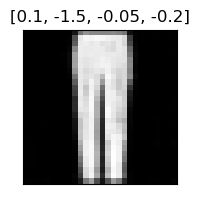

In [27]:
plot_reconstructed_one(vae.decoder, x1=0.1,x2=-1.5,x3=-.05,x4=-0.2)

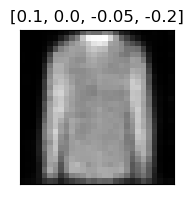

In [28]:
plot_reconstructed_one(vae.decoder, x1=0.1,x2=0.0,x3=-.05,x4=-0.2)

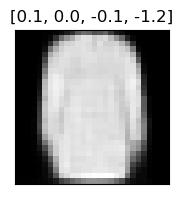

In [29]:
plot_reconstructed_one(vae.decoder, x1=0.1,x2=0.0,x3=-0.1,x4=-1.2)

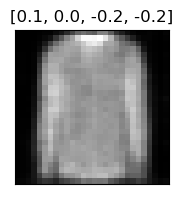

In [30]:
plot_reconstructed_one(vae.decoder, x1=0.1,x2=0.0,x3=-0.2,x4=-0.2)